# Анализ эксперимента по изменению цены премиум-подписки

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Необходимо проверить:

Был ли эксперимент успешен в целом?

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

## Данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

**users_*.csv – информация о пользователях:**

*uid* – идентификатор пользователя  
*age* – возраст  
*attraction_coeff* – коэффициент привлекательности  
*coins* – число монеток (внутренняя валюта)  
*country* – страна  
*visit_days* – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)  
*gender* – пол  
*age_filter_start*  – фильтр поиска, мин. значение  
*age_filter_end*  – фильтр поиска, макс. значение  
*views_count* – число полученных оценок  
*was_premium* – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)  
*is_premium* –  является ли премиум  
*total_revenue* – нормированная выручка  

**transactions_*.csv – информация о платежах пользователей:**

*uid* – идентификатор пользователя  
*country* – страна  
*joined_at* – дата и время регистрации  
*paid_at* – дата и время покупки  
*revenue* – нормированная выручка  
*payment_id* – идентификатор платежа  
*from_page* – откуда пользователь перешел на страницу оплаты  
*product_type* – тип продукта (*trial_premium* – пробная премиум-подписка, *premium_no_trial* – премиум-подписка без пробной, *coins* – подписка за внутреннюю валюту, *other_type* – другое)  

**Файлы:**

*users_test* – информация о пользователях в тестовой группе.   
*users_control_1* – информация о пользователях в первой контрольной группе.   
*users_control_2* – информация о пользователях во второй контрольной группе.   
*transactions_test* – информация о платежах пользователей в тестовой группе.   
*transactions_control_1* – информация о платежах пользователей в первой контрольной группе.   
*transactions_control_2* – информация о платежах пользователей во второй контрольной группе.   

In [1]:
#Импортируем необходимые для работы библиотеки

import pandas as pd
import requests
from urllib.parse import urlencode
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Прочитаем необходимые нам файлы напрямую с ЯндексДиска

def load_csv(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    with open('downloaded_file.csv', 'wb') as f:   
        f.write(download_response.content)    
    df = pd.read_csv('downloaded_file.csv', sep=';', encoding='cp1251')
    os.remove('downloaded_file.csv')
    return df

users_test = load_csv('https://disk.yandex.ru/d/4XXIME4osGrMRA')
users_control_1 = load_csv('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
users_control_2 = load_csv('https://disk.yandex.ru/d/br6KkQupzzTGoQ')
transactions_test = load_csv('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
transactions_control_1 = load_csv('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
transactions_control_2 = load_csv('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

**Проведём EDA для каждого из представленных файлов с данными**

**users_test**

In [3]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [4]:
# Посмотрим общую информацию о датафрейме
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


**Изучим каждый столбец в отдельности**

**uid**

In [5]:
users_test['uid'].describe()

count    4.308000e+03
mean     8.917437e+08
std      4.547670e+05
min      8.910511e+08
25%      8.913621e+08
50%      8.917290e+08
75%      8.920952e+08
max      9.051586e+08
Name: uid, dtype: float64

Отрицательных и нулевых значений в uid не выявлено.

In [6]:
# Проверим, все ли uid у нас уникальные
users_test['uid'].nunique()

4308

Кол-во уникальных uid равно кол-ву строк в датафрейме, из чего можно сделать вывод, что все uid уникальны, соответственно дубликатов у  нас нет.

**age**

In [7]:
users_test['age'].describe()

count    4308.000000
mean       31.889276
std        10.245287
min        16.000000
25%        25.000000
50%        30.000000
75%        38.000000
max        99.000000
Name: age, dtype: float64

Отрицательных и нулевых значений в age не выявлено.  
Минимальный возраст пользователей - 16 лет.  
Максимальный возраст пользователей - 99 лет.  
Средний возраст пользователей - 32 года.

Минимальный и максимальный возраст вызывают вопросы в адекватности данных, посмотрим данные отдельно для пользователей младше 18 лет и отдельно для пользователей старше 79 лет.

In [8]:
# Отберём пользователей младше 18 лет и посмотрим данные по датафрейму
ut_minor = users_test[users_test['age'] < 18]
ut_minor.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,1.050000e+02,105.000000,105.000000,2.000000,105.000000,105.000000,105.000000,105.000000,15.0,2.0,105.000000
mean,8.918660e+08,16.219048,194.019048,4236.000000,0.933333,16.447619,26.123810,150.476190,1.0,1.0,271.761905
std,1.370382e+06,0.415585,297.931651,5982.123369,0.250640,3.119359,16.469491,1253.990646,0.0,0.0,2784.730858
min,8.910596e+08,16.000000,0.000000,6.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913808e+08,16.000000,0.000000,2121.000000,1.000000,16.000000,20.000000,0.000000,1.0,1.0,0.000000
50%,8.917223e+08,16.000000,0.000000,4236.000000,1.000000,16.000000,20.000000,1.000000,1.0,1.0,0.000000
75%,8.921077e+08,16.000000,333.000000,6351.000000,1.000000,16.000000,20.000000,7.000000,1.0,1.0,0.000000
max,9.051586e+08,17.000000,1000.000000,8466.000000,1.000000,30.000000,99.000000,12831.000000,1.0,1.0,28535.000000


Кол-во пользователей младше 18 лет - 105 человек.  
Посмотрев на данные можно сделать вывод, что возраст указан не ошибочно, т.к. средние показатели по age_filter_start (примерно 16 лет) и age_filter_end (примерно 26 лет) в целом укладываются в норму.  
По столбцу total_revenue видно, что кто-то даже приносит доход и платит за подписку, посмотрим на этих пользователей.

In [9]:
ut_minor[ut_minor['total_revenue'] > 0].sort_values('total_revenue', ascending = False)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
553,892097937,17,124,6.0,Chile,"1,2,3,4,5,6,7,8,9,10,12,14,15,16,17,18,21,22,2...",1,14,20,193,1.0,1.0,28535


Найден один пользователь младше 18 лет, который принес выручку в 28535, его uid - 892097937.

In [10]:
# Посчитаем долю пользователей младше 18 лет
((users_test["age"] < 18) * 100).mean()

2.437325905292479

Примерно 2,44% пользователей младше 18 лет.

In [11]:
# Отберём пользователей старше 79 лет и посмотрим данные по датафрейму
ut_elder = users_test[users_test['age'] > 79]
ut_elder.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,9.000000e+00,9.000000,9.000000,1.0,9.0,9.000000,9.000000,9.000000,1.0,1.0,9.000000
mean,8.915625e+08,97.111111,269.666667,72.0,1.0,32.777778,50.000000,47.111111,1.0,1.0,5249.111111
std,3.746775e+05,5.301991,282.381391,NaN,0.0,16.686655,20.451161,78.397137,NaN,NaN,15747.333333
min,8.911751e+08,83.000000,0.000000,72.0,1.0,16.000000,22.000000,0.000000,1.0,1.0,0.000000
25%,8.913219e+08,99.000000,0.000000,72.0,1.0,16.000000,36.000000,3.000000,1.0,1.0,0.000000
50%,8.914284e+08,99.000000,166.000000,72.0,1.0,27.000000,47.000000,6.000000,1.0,1.0,0.000000
75%,8.916330e+08,99.000000,500.000000,72.0,1.0,50.000000,70.000000,30.000000,1.0,1.0,0.000000
max,8.922856e+08,99.000000,666.000000,72.0,1.0,50.000000,70.000000,187.000000,1.0,1.0,47242.000000


Кол-во пользователей старше 79 лет - 9 человек.  
Посмотрев на данные можно сделать вывод, что возраст скорее всего указан ошибочно, т.к. средние показатели по age_filter_start (примерно 33 года) и age_filter_end (50 лет) выглядят очень странно.  
Посмотрим на данные этих 9 человек.

In [12]:
ut_elder

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1747,892285575,99,166,NaN,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,2...",1,50,70,6,NaN,NaN,0
2281,891321930,99,0,NaN,United States of America,"1,2,4,6",1,50,70,3,NaN,NaN,0
2374,891305103,99,666,NaN,France,"1,2,3,4,5,6,7,8,9",1,27,36,9,NaN,NaN,0
2472,891632982,83,0,NaN,Italy,1,1,50,70,0,NaN,NaN,0
2642,892065108,99,475,72.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,2...",1,16,41,187,1.0,1.0,47242
2794,891346023,99,0,NaN,Italy,NaN,1,50,70,3,NaN,NaN,0
3107,891502608,98,33,NaN,Kyrgyzstan,1,1,16,22,30,NaN,NaN,0
4225,891428367,99,500,NaN,Portugal,1,1,20,47,4,NaN,NaN,0
4265,891175101,99,587,NaN,Canada,1,1,16,24,182,NaN,NaN,0


Посмотрев на данные можно подтвердить вывод, что возраст указан ошибочно, т.к. age_filter_start и age_filter_end далеко отличаются от возраста пользователей.  
Также найден пользователь из этой группы, который принес больше всего выручки - 47242, его uid - 892065108.

In [13]:
# Посчитаем долю пользователей старше 79 лет (как мы выяснили пользователей с ошибочным возрастом)
((users_test["age"] > 79) * 100).mean()

0.20891364902506965

Примерно 0,2% пользователей старше 79 лет (с неверно указаным возрастом).

**attraction_coeff**

In [14]:
users_test['attraction_coeff'].describe()

count    4308.000000
mean      316.411328
std       323.373725
min         0.000000
25%         0.000000
50%       250.000000
75%       520.250000
max      1000.000000
Name: attraction_coeff, dtype: float64

Отрицательных значений в attraction_coeff не выявлено.    
Среднее значение - 316.  

**coins**

In [15]:
users_test['coins'].describe()

count      49.000000
mean      229.836735
std      1205.819471
min         1.000000
25%         4.000000
50%         9.000000
75%        72.000000
max      8466.000000
Name: coins, dtype: float64

Отрицательных значений в coins не выявлено, но, когда мы смотрели users_test.info(), то видно, что есть значения NaN.

In [16]:
# Заменим значения Nan на нули
users_test["coins"] = users_test["coins"].fillna(0)

In [17]:
# Посмотрим на обновленные данные
users_test['coins'].describe()

count    4308.000000
mean        2.614206
std       129.608910
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      8466.000000
Name: coins, dtype: float64

Максимальное количество монеток - 8466.  
Среднее значение - 2,6.  

In [18]:
# Найдём пользователя с наибольшим кол-вом монеток
users_test[users_test['coins'] == users_test['coins'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
2937,905158620,16,579,8466.0,Russian Federation,"1,2,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,26,...",0,26,33,12831,1.0,1.0,0


uid пользователя с наибольшим кол-вом монеток - 905158620, у него довольно высокий показатель views_count, при этом у него есть активный премиум, но никакого дохода мы с него не получаем, видимо оплачивает с монеток.

**country**

In [19]:
users_test['country'].value_counts(dropna=False)

United States of America          1450
Argentina                          396
France                             359
Italy                              323
Spain                              301
Chile                              272
United Arab Emirates               226
Germany                            209
United Kingdom (Great Britain)     169
Canada                             137
Israel                             106
Belgium                             92
Portugal                            91
Australia                           62
Switzerland                         35
Ukraine                             15
Russian Federation                   7
Mexico                               7
Turkey                               5
India                                4
Indonesia                            4
Tunisia                              3
Morocco                              3
Latvia                               2
Algeria                              2
Pakistan                 

Наибольшее кол-во пользователей из США - 1450 пользователей.  
Пустых значений не выявлено.

**visit_days**

В данной колонке мы не сможем посмотреть информацию, как мы делали это в предыдущих.  
Но предлагаю преобразовать текст в данном столбце в список, а значения NaN перевести в пустые списки.  
Также предлагаю сделать отдельный столбец с кол-вом дней посещения, чтобы можно было узнать активность пользователей.  

In [20]:
# Преобразуем строки в списки и обработаем NaN значения
users_test['visit_days'] = users_test['visit_days'].apply(
    lambda x: [int(i.strip()) for i in x.split(',')] if pd.notna(x) else [])

In [21]:
# Добавим новый столбец с количеством посещений
users_test['visits_count'] = users_test['visit_days'].str.len()

In [22]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
0,892309896,27,685,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]",1,24,30,89,NaN,NaN,0,14
1,892044516,27,0,0.0,Germany,[],1,24,30,0,NaN,NaN,0,0
2,892185708,45,44,0.0,Israel,"[1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16,...",1,42,48,68,NaN,NaN,0,20
3,892130292,32,0,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",1,29,35,0,NaN,NaN,0,12
4,891406035,27,1000,0.0,France,[],1,24,30,1,1.0,NaN,0,0


In [23]:
# Найдём самых активных пользователей
users_test[users_test['visits_count'] == users_test['visits_count'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
1509,892364877,24,650,0.0,India,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,21,27,20,NaN,NaN,0,31
1731,892392114,46,759,0.0,Italy,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,38,55,345,NaN,NaN,0,31
3418,892437846,30,829,0.0,Canada,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,27,33,82,NaN,NaN,0,31
4037,892366992,31,1000,0.0,France,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,28,34,1,NaN,NaN,0,31


**gender**

In [24]:
users_test['gender'].value_counts()

1    4106
0     202
Name: gender, dtype: int64

Пользователей с полом 1 - 4106.  
Пользователей с полом 0 - 202.  
Т.к. мы не знаем, под какой цифрой какой пол, попробуем предположить.  
За основу возьмём логику, что мужской пол чаще всего ищет партнера младше своего возраста, а женский пол наоборот старше своего возраста. Но также не будем забывать, что оба пола могут искать партнеров своего возраста.

In [25]:
# Посчитаем кол-во пользователей с разным полом в зависимости от среднего возраста партнера
users_test.groupby('gender', as_index = False).apply(
    lambda x: pd.Series({
        'younger': ((x['age_filter_start'] + x['age_filter_end']) / 2 < x['age']).sum(),
        'equal': ((x['age_filter_start'] + x['age_filter_end']) / 2 == x['age']).sum(),
        'older': ((x['age_filter_start'] + x['age_filter_end']) / 2 > x['age']).sum()}))

,gender,younger,equal,older
0,0,9,116,77
1,1,680,2779,647


На основе полученной таблицы можно сделать вывод, что 0 - это женский пол, т.к. возраст старше встречается чаще, чем младший возраст, а 1 - это мужской пол, т.к. возраст младше встречается чаще, чем старший. К тому же по статистике мужской пол чаще пользуется приложениями для знакомств, чем женский. Так что наш вывод выглядит вполне логичным.  
  
Итого:  
Пользователей мужского пола - 4106.  
Пользователей женского пола - 202.  

**age_filter_start**

In [26]:
users_test['age_filter_start'].describe()

count    4308.000000
mean       26.701486
std         9.390851
min        13.000000
25%        19.000000
50%        24.000000
75%        32.000000
max        96.000000
Name: age_filter_start, dtype: float64

Нулевых и отрицательных значений не выявлено.  
Минимальный возраст - 13 лет.  
Максимальный возраст - 96 лет.  
Средний возраст - 27 лет.  

**age_filter_end**

In [27]:
users_test['age_filter_end'].describe()

count    4308.000000
mean       38.248839
std        15.344562
min        19.000000
25%        28.000000
50%        35.000000
75%        44.000000
max       102.000000
Name: age_filter_end, dtype: float64

Нулевых и отрицательных значений не выявлено.  
Минимальный возраст - 19 лет.  
Максимальный возраст - 102 года.  
Средний возраст - 38 лет.

In [28]:
# Проверим, не нарушена ли где-то логика фильтра возраста (нет ли строк, где age_filter_start больше, чем age_filter_end)
(users_test['age_filter_start'] <= users_test['age_filter_end']).all()

True

Логика не нарушена. Во всех строках age_filter_start меньше, либо равен age_filter_end.

**views_count**

In [29]:
users_test['views_count'].describe()

count     4308.000000
mean        50.391133
std        318.676437
min          0.000000
25%          1.000000
50%          6.000000
75%         22.000000
max      12831.000000
Name: views_count, dtype: float64

Отрицательных значений не выявлено.  
Среднее кол-во полученных оценок - 50.  
Максимальное кол-во полученных оценок - 12831.  

**was_premium**

In [30]:
users_test['was_premium'].value_counts(dropna=False)

NaN    3900
1.0     408
Name: was_premium, dtype: int64

Отрицательных значений не выявлено.  
Преобразуем NaN в нули и приведём значения к int.  

In [31]:
# Преобразование
users_test['was_premium'] = users_test['was_premium'].fillna(0).astype(int)

In [32]:
# Проверяем, что получилось
users_test['was_premium'].value_counts(dropna=False)

0    3900
1     408
Name: was_premium, dtype: int64

Пользователей, у которых никогда не было премиума - 3900 человек.  
Пользователй, у которых был хоть раз премиум - 408 человек.

**is_premium**

In [33]:
users_test['is_premium'].value_counts(dropna=False)

NaN    4151
1.0     157
Name: is_premium, dtype: int64

Отрицательных значений не выявлено.  
Преобразуем NaN в нули и приведём значения к int.  

In [34]:
# Преобразование
users_test['is_premium'] = users_test['is_premium'].fillna(0).astype(int)

In [35]:
# Проверяем, что получилось
users_test['is_premium'].value_counts(dropna=False)

0    4151
1     157
Name: is_premium, dtype: int64

На момент сбора данных:  
Пользователей, у которых есть премиум - 157 человек.  
Пользователй, у которых нет премиума - 4151 человек.

Проверим данные на условие, что у пользователя в столбце was_premium указан 0, но при этом в столбце was_premium указана 1.  Такого быть не должно, это противоречит логике.

In [36]:
(users_test["was_premium"] < users_test["is_premium"]).value_counts()

False    4308
dtype: int64

Ошибок не выявлено.

**total_revenue**

In [37]:
users_test['total_revenue'].describe()

count      4308.000000
mean        534.080316
std        4371.682632
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      129870.000000
Name: total_revenue, dtype: float64

Отрицательных значений не выявлено.  
Средняя выручка - 534.  
Максимальная выручка - 129870.

Посмотрим на пользователя с самой большой выручкой.

In [38]:
users_test[users_test['total_revenue'] == users_test['total_revenue'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
3629,891178380,42,275,85.0,Spain,"[1, 2, 4, 5, 6, 7]",1,26,36,287,1,1,129870,6


Это пользователь с uid - 891178380, самая большая выручка, но кол-во оценок не такое большое, так же не очень часто заходил в приложение, но возможно не так давно им пользуется.

**users_control_1**

In [39]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [40]:
# Посмотрим общую информацию о датафрейме
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


**Изучим каждый столбец в отдельности**

**uid**

In [41]:
users_control_1['uid'].describe()

count    4.340000e+03
mean     8.917578e+08
std      1.125683e+06
min      8.910510e+08
25%      8.913626e+08
50%      8.917272e+08
75%      8.920898e+08
max      9.609370e+08
Name: uid, dtype: float64

Отрицательных и нулевых значений в uid не выявлено.

In [42]:
# Проверим, все ли uid у нас уникальные
users_control_1['uid'].nunique()

4340

Кол-во уникальных uid равно кол-ву строк в датафрейме, из чего можно сделать вывод, что все uid уникальны, соответственно дубликатов у  нас нет.

**age**

In [43]:
users_control_1['age'].describe()

count    4340.000000
mean       32.095392
std        10.257466
min        16.000000
25%        24.000000
50%        30.000000
75%        38.000000
max        99.000000
Name: age, dtype: float64

Отрицательных и нулевых значений в age не выявлено.  
Минимальный возраст пользователей - 16 лет.  
Максимальный возраст пользователей - 99 лет.  
Средний возраст пользователей - 32 года.

Минимальный и максимальный возраст вызывают вопросы в адекватности данных, посмотрим данные отдельно для пользователей младше 18 лет и отдельно для пользователей старше 79 лет.

In [44]:
# Отберём пользователей младше 18 лет и посмотрим данные по датафрейму
uс1_minor = users_control_1[users_control_1['age'] < 18]
uс1_minor.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,1.040000e+02,104.000000,104.000000,0.0,104.000000,104.000000,104.000000,104.000000,6.0,1.0,104.000000
mean,8.918334e+08,16.211538,170.923077,NaN,0.855769,17.471154,28.086538,49.721154,1.0,1.0,79.625000
std,3.880166e+05,0.410377,270.730428,NaN,0.353025,5.519527,18.266161,206.250223,0.0,NaN,661.960243
min,8.910723e+08,16.000000,0.000000,NaN,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.914429e+08,16.000000,0.000000,NaN,1.000000,16.000000,20.000000,0.000000,1.0,1.0,0.000000
50%,8.918973e+08,16.000000,0.000000,NaN,1.000000,16.000000,20.000000,1.000000,1.0,1.0,0.000000
75%,8.921769e+08,16.000000,333.000000,NaN,1.000000,16.000000,24.250000,8.000000,1.0,1.0,0.000000
max,8.924400e+08,17.000000,1000.000000,NaN,1.000000,48.000000,99.000000,1506.000000,1.0,1.0,6539.000000


Кол-во пользователей младше 18 лет - 104 человека.  
Посмотрев на данные можно сделать вывод, что возраст указан не ошибочно, т.к. средние показатели по age_filter_start (примерно 17 лет) и age_filter_end (примерно 28 лет) в целом укладываются в норму.  
По столбцу total_revenue видно, что кто-то даже приносит доход и платит за подписку, посмотрим на этих пользователей.

In [45]:
uс1_minor[uс1_minor['total_revenue'] > 0].sort_values('total_revenue', ascending = False)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1755,892172853,16,320,NaN,Italy,"1,2,17",1,16,20,25,1.0,1.0,6539
3843,891983730,17,78,NaN,Israel,"1,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22",1,17,20,76,1.0,NaN,1742


Найдено два пользователя младше 18 лет, которые принесли выручку в общей сумме 8281, их uid - 892172853 и 891983730.

In [46]:
# Посчитаем долю пользователей младше 18 лет
((users_control_1["age"] < 18) * 100).mean()

2.3963133640552994

Примерно 2,39% пользователей младше 18 лет.

In [47]:
# Отберём пользователей старше 79 лет и посмотрим данные по датафрейму
uc1_elder = users_control_1[users_control_1['age'] > 79]
uc1_elder.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,9.000000e+00,9.000000,9.000000,0.0,9.0,9.000000,9.000000,9.000000,1.0,1.0,9.000000
mean,8.919714e+08,98.000000,425.666667,NaN,1.0,36.777778,74.222222,68.777778,1.0,1.0,814.666667
std,3.342660e+05,2.645751,297.739399,NaN,0.0,26.522527,32.866312,149.451311,NaN,NaN,2444.000000
min,8.913741e+08,91.000000,0.000000,NaN,1.0,16.000000,23.000000,0.000000,1.0,1.0,0.000000
25%,8.917466e+08,99.000000,300.000000,NaN,1.0,16.000000,49.000000,4.000000,1.0,1.0,0.000000
50%,8.919184e+08,99.000000,384.000000,NaN,1.0,22.000000,99.000000,13.000000,1.0,1.0,0.000000
75%,8.922788e+08,99.000000,593.000000,NaN,1.0,50.000000,99.000000,32.000000,1.0,1.0,0.000000
max,8.923352e+08,99.000000,900.000000,NaN,1.0,96.000000,102.000000,462.000000,1.0,1.0,7332.000000


Кол-во пользователей старше 79 лет - 9 человек.  
Посмотрев на данные можно сделать вывод, что возраст скорее всего указан ошибочно, т.к. средние показатели по age_filter_start (примерно 37 лет) и age_filter_end (74 года) выглядят очень странно.  
Посмотрим на данные этих 9 человек.

In [48]:
uc1_elder

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
773,891746646,99,300,NaN,Italy,NaN,1,50,70,10,NaN,NaN,0
1466,891918399,99,62,NaN,Italy,"1,2,3",1,50,99,16,NaN,NaN,0
1856,891374112,99,900,NaN,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11",1,16,99,462,NaN,NaN,0
2103,892185039,99,759,NaN,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9",1,43,49,79,1.0,1.0,7332
2238,892321845,99,500,NaN,United States of America,NaN,1,22,99,4,NaN,NaN,0
2312,891682545,99,0,NaN,United States of America,NaN,1,96,102,0,NaN,NaN,0
2836,891900387,99,333,NaN,Italy,"1,3,4",1,16,99,3,NaN,NaN,0
2908,892335240,98,593,NaN,United States of America,1,1,22,28,32,NaN,NaN,0
3399,892278777,91,384,NaN,United Arab Emirates,1,1,16,23,13,NaN,NaN,0


Посмотрев на данные можно подтвердить вывод, что возраст указан ошибочно, т.к. age_filter_start и age_filter_end далеко отличаются от возраста пользователей.  
Но есть один пользватель, у которого скорее всего возраст указан верно, это пользователь с uid - 891682545, там возраст пользователя верно попадаем в рамки поиска партнера.  
Также найден пользователь из этой группы, который принес больше всего выручки - 7332, его uid - 892185039.

In [49]:
# Посчитаем долю пользователей старше 79 лет
((users_control_1["age"] > 79) * 100).mean()

0.2073732718894009

Примерно 0,2% пользователей старше 79 лет.

**attraction_coeff**

In [50]:
users_control_1['attraction_coeff'].describe()

count    4340.000000
mean      312.048848
std       320.972130
min         0.000000
25%         0.000000
50%       238.500000
75%       518.000000
max      1000.000000
Name: attraction_coeff, dtype: float64

Отрицательных значений в attraction_coeff не выявлено.    
Среднее значение - 312.  

**coins**

In [51]:
users_control_1['coins'].describe()

count       60.0000
mean      1745.9000
std      12902.3577
min          1.0000
25%          8.0000
50%         11.5000
75%         28.0000
max      99958.0000
Name: coins, dtype: float64

Отрицательных значений в coins не выявлено, но, когда мы смотрели users_control_1.info(), то видно, что есть знаения NaN.

In [52]:
# Заменим значения Nan на нули
users_control_1["coins"] = users_control_1["coins"].fillna(0)

In [53]:
# Посмотрим на обновленные данные
users_control_1['coins'].describe()

count     4340.000000
mean        24.136866
std       1518.279250
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99958.000000
Name: coins, dtype: float64

Максимальное количество монеток - 99958.  
Среднее значение - 24.  

In [54]:
# Найдём пользователя с наибольшим кол-вом монеток
users_control_1[users_control_1['coins'] == users_control_1['coins'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26


uid пользователя с наибольшим кол-вом монеток - 960936960, у него есть активный премиум, но дохода мы с него получаем мизерный, всего 26, видимо оплачивает подписки с монеток.

**country**

In [55]:
users_control_1['country'].value_counts(dropna=False)

United States of America          1471
Argentina                          389
France                             370
Spain                              342
Italy                              338
Chile                              287
United Arab Emirates               207
Germany                            188
United Kingdom (Great Britain)     146
Canada                             134
Israel                             109
Belgium                            108
Portugal                           100
Australia                           50
Switzerland                         42
Ukraine                              8
Turkey                               8
Russian Federation                   6
India                                6
Mexico                               4
Tunisia                              3
Venezuela                            2
Dominican Republic                   2
Algeria                              2
Puerto Rico                          2
Egypt                    

Наибольшее кол-во пользователей из США - 1471 пользователей.  
Пустых значений не выявлено.

**visit_days**

В данной колонке мы не сможем посмотреть информацию, как мы делали это в предыдущих.  
Но предлагаю преобразовать текст в данном столбце в список, а значения NaN перевести в пустые списки.  
Также предлагаю сделать отдельный столбец с кол-вом дней посещения, чтобы можно было узнать активность пользователей.  

In [56]:
# Преобразуем строки в списки и обработаем NaN значения
users_control_1['visit_days'] = users_control_1['visit_days'].apply(
    lambda x: [int(i.strip()) for i in x.split(',')] if pd.notna(x) else [])

In [57]:
# Добавим новый столбец с количеством посещений
users_control_1['visits_count'] = users_control_1['visit_days'].str.len()

In [58]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
0,892319115,25,435,0.0,United States of America,"[1, 2, 3, 4, 5, 6]",0,22,32,982,NaN,NaN,0,6
1,891248523,29,500,0.0,United States of America,"[1, 2]",1,26,32,12,NaN,NaN,0,2
2,891670932,33,800,0.0,France,"[1, 2, 3, 5, 6, 8, 9, 11, 13, 16]",1,30,36,5,NaN,NaN,0,10
3,891060786,26,0,0.0,Argentina,"[1, 2, 3, 4, 5]",1,23,29,0,NaN,NaN,0,5
4,892006554,35,294,0.0,United States of America,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19]",1,30,40,17,NaN,NaN,0,14


In [59]:
# Найдём самых активных пользователей
users_control_1[users_control_1['visits_count'] == users_control_1['visits_count'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
23,892379115,23,948,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,20,99,411,NaN,NaN,0,31
107,892380033,29,535,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,25,31,142,1.0,1.0,4732,31
179,892337712,49,677,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,31,41,493,NaN,NaN,0,31
284,892421277,22,446,62.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,16,35,130,1.0,1.0,60333,31
300,892360221,30,205,0.0,Italy,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,24,28,68,NaN,NaN,0,31
346,892353996,32,800,0.0,Chile,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,17,44,5,NaN,NaN,0,31
847,892423284,45,465,0.0,Belgium,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,45,49,243,1.0,1.0,12909,31
906,892359621,30,649,0.0,France,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,31,43,208,NaN,NaN,0,31
930,892420683,37,268,0.0,Israel,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,25,40,97,NaN,NaN,0,31
1766,892335696,31,200,0.0,Israel,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,16,99,5,NaN,NaN,0,31


**gender**

In [60]:
users_control_1['gender'].value_counts()

1    4158
0     182
Name: gender, dtype: int64

Мы определились, что под 0 - это женский пол, а под 1 - это мужской пол, получаем:  
Пользователей мужского пола - 4158 человек.
Пользователей женского пола - 182 человек.

**age_filter_start**

In [61]:
users_control_1['age_filter_start'].describe()

count    4340.000000
mean       26.793779
std         9.405103
min        13.000000
25%        19.000000
50%        25.000000
75%        32.000000
max        96.000000
Name: age_filter_start, dtype: float64

Нулевых и отрицательных значений не выявлено.  
Минимальный возраст - 13 лет.  
Максимальный возраст - 96 лет.  
Средний возраст - 27 лет.

**age_filter_end**

In [62]:
users_control_1['age_filter_end'].describe()

count    4340.000000
mean       38.553226
std        15.226951
min        19.000000
25%        28.000000
50%        35.000000
75%        45.000000
max       102.000000
Name: age_filter_end, dtype: float64

Нулевых и отрицательных значений не выявлено.  
Минимальный возраст - 19 лет.  
Максимальный возраст - 102 года.  
Средний возраст - 39 лет.

In [63]:
# Проверим, не нарушена ли где-то логика фильтра возраста (нет ли строк, где age_filter_start больше, чем age_filter_end)
(users_control_1['age_filter_start'] <= users_control_1['age_filter_end']).all()

True

Логика не нарушена. Во всех строках age_filter_start меньше, либо равен age_filter_end.

**views_count**

In [64]:
users_control_1['views_count'].describe()

count    4340.000000
mean       44.467512
std       204.800272
min         0.000000
25%         1.000000
50%         6.000000
75%        21.000000
max      4953.000000
Name: views_count, dtype: float64

Отрицательных значений не выявлено.  
Среднее кол-во полученных оценок - 44.  
Максимальное кол-во полученных оценок - 4953.  

**was_premium**

In [65]:
users_control_1['was_premium'].value_counts(dropna=False)

NaN    3904
1.0     436
Name: was_premium, dtype: int64

Отрицательных значений не выявлено.  
Преобразуем NaN в нули и приведём значения к int.  

In [66]:
# Преобразование
users_control_1['was_premium'] = users_control_1['was_premium'].fillna(0).astype(int)

In [67]:
# Проверяем, что получилось
users_control_1['was_premium'].value_counts(dropna=False)

0    3904
1     436
Name: was_premium, dtype: int64

Пользователей, у которых никогда не было премиума - 3904 человека.  
Пользователй, у которых был хоть раз премиум - 436 человек.

**is_premium**

In [68]:
users_control_1['is_premium'].value_counts(dropna=False)

NaN    4148
1.0     192
Name: is_premium, dtype: int64

Отрицательных значений не выявлено.  
Преобразуем NaN в нули и приведём значения к int.  

In [69]:
# Преобразование
users_control_1['is_premium'] = users_control_1['is_premium'].fillna(0).astype(int)

In [70]:
# Проверяем, что получилось
users_control_1['is_premium'].value_counts(dropna=False)

0    4148
1     192
Name: is_premium, dtype: int64

На момент сбора данных:  
Пользователей, у которых есть премиум - 192 человека.  
Пользователй, у которых нет премиума - 4148 человек.

Проверим данные на условие, что у пользователя в столбце was_premium указан 0, но при этом в столбце was_premium указана 1.  Такого быть не должно, это противоречит логике.

In [71]:
(users_control_1["was_premium"] < users_control_1["is_premium"]).value_counts()

False    4340
dtype: int64

Ошибок не выявлено.

**total_revenue**

In [72]:
users_control_1['total_revenue'].describe()

count      4340.000000
mean        594.761982
std        7987.922925
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      486330.000000
Name: total_revenue, dtype: float64

Отрицательных значений не выявлено.  
Средняя выручка - 595.  
Максимальная выручка - 486330.

Посмотрим на пользователя с самой большой выручкой.

In [73]:
users_control_1[users_control_1['total_revenue'] == users_control_1['total_revenue'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
1427,892333905,22,175,3608.0,Italy,"[1, 2, 3, 4, 5, 6, 7, 15]",1,19,25,575,1,1,486330,8


Это пользователь с uid - 892333905, самая большая выручка, даже чересчур большая, учитывая, что пользуется не так часто приложением. 

**users_control_2**

In [74]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [75]:
# Посмотрим общую информацию о датафрейме
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


**Изучим каждый столбец в отдельности**

**uid**

In [76]:
users_control_2['uid'].describe()

count    4.264000e+03
mean     8.917694e+08
std      2.520759e+06
min      8.910509e+08
25%      8.913453e+08
50%      8.917205e+08
75%      8.920735e+08
max      1.053059e+09
Name: uid, dtype: float64

Отрицательных и нулевых значений в uid не выявлено.

In [77]:
# Проверим, все ли uid у нас уникальные
users_control_2['uid'].nunique()

4264

Кол-во уникальных uid равно кол-ву строк в датафрейме, из чего можно сделать вывод, что все uid уникальны, соответственно дубликатов у  нас нет.

**age**

In [78]:
users_control_2['age'].describe()

count    4264.000000
mean       32.046201
std        10.170721
min        16.000000
25%        25.000000
50%        30.000000
75%        38.000000
max        99.000000
Name: age, dtype: float64

Отрицательных и нулевых значений в age не выявлено.  
Минимальный возраст пользователей - 16 лет.  
Максимальный возраст пользователей - 99 лет.  
Средний возраст пользователей - 32 года.

Минимальный и максимальный возраст вызывают вопросы в адекватности данных, посмотрим данные отдельно для пользователей младше 18 лет и отдельно для пользователей старше 79 лет.

In [79]:
# Отберём пользователей младше 18 лет и посмотрим данные по датафрейму
uс2_minor = users_control_2[users_control_2['age'] < 18]
uс2_minor.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,9.600000e+01,96.000000,96.000000,1.0,96.000000,96.000000,96.000000,96.000000,3.0,2.0,96.000000
mean,8.918141e+08,16.093750,159.041667,16.0,0.916667,16.916667,29.500000,17.583333,1.0,1.0,285.458333
std,4.107453e+05,0.293011,288.813723,NaN,0.277836,4.201921,22.146403,79.030263,0.0,0.0,1854.764953
min,8.910804e+08,16.000000,0.000000,16.0,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.914080e+08,16.000000,0.000000,16.0,1.000000,16.000000,20.000000,0.000000,1.0,1.0,0.000000
50%,8.918524e+08,16.000000,0.000000,16.0,1.000000,16.000000,20.000000,1.000000,1.0,1.0,0.000000
75%,8.921924e+08,16.000000,234.500000,16.0,1.000000,16.000000,22.250000,6.250000,1.0,1.0,0.000000
max,8.924393e+08,17.000000,1000.000000,16.0,1.000000,45.000000,99.000000,680.000000,1.0,1.0,16562.000000


Кол-во пользователей младше 18 лет - 96 человек.  
Посмотрев на данные можно сделать вывод, что возраст указан не ошибочно, т.к. средние показатели по age_filter_start (примерно 16 лет) и age_filter_end (примерно 30 лет) в целом укладываются в норму.  
По столбцу total_revenue видно, что кто-то даже приносит доход и платит за подписку, посмотрим на этих пользователей.

In [80]:
uс2_minor[uс2_minor['total_revenue'] > 0].sort_values('total_revenue', ascending = False)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
20,892164795,16,0,NaN,France,NaN,1,16,20,0,1.0,1.0,16562
2408,892069761,16,90,16.0,Argentina,"1,2,3",1,16,20,11,NaN,NaN,6305
1193,891290967,16,750,NaN,United States of America,NaN,1,16,20,4,1.0,1.0,4537


Найдено три пользователя младше 18 лет, которые принесли выручку в общей сумме 27404, их uid - 892164795, 892069761 и 891290967.

In [81]:
# Посчитаем долю пользователей младше 18 лет
((users_control_2["age"] < 18) * 100).mean()

2.25140712945591

Примерно 2,25% пользователей младше 18 лет.

In [82]:
# Отберём пользователей старше 79 лет и посмотрим данные по датафрейму
uc2_elder = users_control_2[users_control_2['age'] > 79]
uc2_elder.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,5.000000e+00,5.000000,5.000000,0.0,5.000000,5.000000,5.000000,5.000000,1.0,1.0,5.000000
mean,8.919218e+08,93.400000,470.600000,NaN,0.800000,25.800000,54.800000,56.400000,1.0,1.0,1775.800000
std,2.395724e+05,5.412947,216.448146,NaN,0.447214,13.863621,29.320641,80.757662,NaN,NaN,3970.809514
min,8.915593e+08,87.000000,213.000000,NaN,0.000000,16.000000,28.000000,3.000000,1.0,1.0,0.000000
25%,8.918942e+08,90.000000,320.000000,NaN,1.000000,18.000000,37.000000,7.000000,1.0,1.0,0.000000
50%,8.919349e+08,92.000000,440.000000,NaN,1.000000,21.000000,40.000000,25.000000,1.0,1.0,0.000000
75%,8.919955e+08,99.000000,666.000000,NaN,1.000000,24.000000,70.000000,50.000000,1.0,1.0,0.000000
max,8.922248e+08,99.000000,714.000000,NaN,1.000000,50.000000,99.000000,197.000000,1.0,1.0,8879.000000


Кол-во пользователей старше 79 лет - 5 человек.  
Посмотрев на данные можно сделать вывод, что возраст скорее всего указан ошибочно, т.к. средние показатели по age_filter_start (примерно 26 лет) и age_filter_end (55 лет) выглядят очень странно.  
Посмотрим на данные этих 5 человек.

In [83]:
uc2_elder

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
137,892224798,92,320,NaN,United States of America,"1,2,4,5,6,7,10,12,15",1,21,28,50,NaN,NaN,0
1100,891995541,99,213,NaN,Ukraine,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,18,99,197,1.0,1.0,8879
2195,891894243,90,714,NaN,New Zealand,1,1,50,70,7,NaN,NaN,0
2571,891559305,99,440,NaN,Germany,"1,2",0,24,37,25,NaN,NaN,0
4189,891934920,87,666,NaN,Italy,"1,2",1,16,40,3,NaN,NaN,0


Посмотрев на данные можно подтвердить вывод, что возраст указан ошибочно, т.к. age_filter_start и age_filter_end далеко отличаются от возраста пользователей.
Также найден пользователь из этой группы, который принес больше всего выручки - 8879, его uid - 891995541.

In [84]:
# Посчитаем долю пользователей старше 79 лет
((users_control_2["age"] > 79) * 100).mean()

0.11726078799249531

Примерно 0,12% пользователей старше 79 лет.

**attraction_coeff**

In [85]:
users_control_2['attraction_coeff'].describe()

count    4264.000000
mean      317.957317
std       326.191737
min         0.000000
25%         0.000000
50%       250.000000
75%       548.500000
max      1000.000000
Name: attraction_coeff, dtype: float64

Отрицательных значений в attraction_coeff не выявлено.    
Среднее значение - 318.  

**coins**

In [86]:
users_control_2['coins'].describe()

count     61.000000
mean      18.147541
std       35.439543
min        1.000000
25%        4.000000
50%       10.000000
75%       20.000000
max      271.000000
Name: coins, dtype: float64

Отрицательных значений в coins не выявлено, но, когда мы смотрели users_control_2.info(), то видно, что есть знаения NaN.

In [87]:
# Заменим значения Nan на нули
users_control_2["coins"] = users_control_2["coins"].fillna(0)

In [88]:
# Посмотрим на обновленные данные
users_control_2['coins'].describe()

count    4264.000000
mean        0.259615
std         4.724639
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       271.000000
Name: coins, dtype: float64

Максимальное количество монеток - 271.  
Среднее значение - 0,25.  

In [89]:
# Найдём пользователя с наибольшим кол-вом монеток
users_control_2[users_control_2['coins'] == users_control_2['coins'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
892,891664350,34,242,271.0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,17,41,541,1.0,1.0,28119


uid пользователя с наибольшим кол-вом монеток - 891664350, у него есть активный премиум, получили доход с него в сумме 28119, всего монеток - 271, берёт подписку скорее всего оплачивая сам.

**country**

In [90]:
users_control_2['country'].value_counts(dropna=False)

United States of America          1486
Argentina                          397
France                             376
Spain                              310
Italy                              293
Chile                              286
United Arab Emirates               211
Germany                            202
United Kingdom (Great Britain)     146
Canada                             134
Portugal                           100
Belgium                             90
Israel                              78
Australia                           51
Switzerland                         35
Ukraine                             18
Russian Federation                   8
Morocco                              5
Turkey                               5
Mexico                               4
Austria                              2
India                                2
Pakistan                             2
Colombia                             2
Czech Republic                       1
Kuwait                   

Наибольшее кол-во пользователей из США - 1486 пользователей.  
Пустых значений не выявлено.

**visit_days**

В данной колонке мы не сможем посмотреть информацию, как мы делали это в предыдущих.  
Но предлагаю преобразовать текст в данном столбце в список, а значения NaN перевести в пустые списки.  
Также предлагаю сделать отдельный столбец с кол-вом дней посещения, чтобы можно было узнать активность пользователей.  

In [91]:
# Преобразуем строки в списки и обработаем NaN значения
users_control_2['visit_days'] = users_control_2['visit_days'].apply(
    lambda x: [int(i.strip()) for i in x.split(',')] if pd.notna(x) else [])

In [92]:
# Добавим новый столбец с количеством посещений
users_control_2['visits_count'] = users_control_2['visit_days'].str.len()

In [93]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
0,892035504,37,137,0.0,Israel,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13]",1,30,40,51,NaN,NaN,0,11
1,891782112,57,0,0.0,Italy,[1],1,54,60,0,NaN,NaN,0,1
2,891110337,30,769,0.0,France,"[1, 2, 3, 4, 5]",1,27,33,13,NaN,NaN,0,5
3,891796320,48,750,0.0,France,"[1, 4, 6, 8, 10, 11, 12, 14, 15, 16, 18]",1,45,51,12,NaN,NaN,0,11
4,891880212,54,638,0.0,United States of America,[1],1,35,53,94,NaN,NaN,0,1


In [94]:
# Найдём самых активных пользователей
users_control_2[users_control_2['visits_count'] == users_control_2['visits_count'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
55,892425369,18,289,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,15,21,107,NaN,NaN,0,31
1873,892437816,18,159,0.0,Argentina,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,16,23,88,NaN,NaN,0,31
2024,892385832,22,373,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,19,25,4762,NaN,NaN,0,31
2702,892339287,26,324,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,23,29,74,NaN,NaN,0,31


**gender**

In [95]:
users_control_2['gender'].value_counts()

1    4069
0     195
Name: gender, dtype: int64

Мы определились, что под 0 - это женский пол, а под 1 - это мужской пол, получаем:  
Пользователей мужского пола - 4069 человек.
Пользователей женского пола - 195 человек.

**age_filter_start**

In [96]:
users_control_2['age_filter_start'].describe()

count    4264.000000
mean       26.954268
std         9.546657
min        13.000000
25%        19.000000
50%        25.000000
75%        32.000000
max        94.000000
Name: age_filter_start, dtype: float64

Нулевых и отрицательных значений не выявлено.  
Минимальный возраст - 13 лет.  
Максимальный возраст - 94 года.  
Средний возраст - 27 лет.

**age_filter_end**

In [97]:
users_control_2['age_filter_end'].describe()

count    4264.000000
mean       38.906895
std        15.955574
min        19.000000
25%        28.000000
50%        35.000000
75%        45.000000
max        99.000000
Name: age_filter_end, dtype: float64

Нулевых и отрицательных значений не выявлено.  
Минимальный возраст - 19 лет.  
Максимальный возраст - 99 лет.  
Средний возраст - 39 лет.

In [98]:
# Проверим, не нарушена ли где-то логика фильтра возраста (нет ли строк, где age_filter_start больше, чем age_filter_end)
(users_control_2['age_filter_start'] <= users_control_2['age_filter_end']).all()

True

Логика не нарушена. Во всех строках age_filter_start меньше, либо равен age_filter_end.

**views_count**

In [99]:
users_control_2['views_count'].describe()

count     4264.000000
mean        45.064493
std        318.188992
min          0.000000
25%          1.000000
50%          6.000000
75%         20.000000
max      16157.000000
Name: views_count, dtype: float64

Отрицательных значений не выявлено.  
Среднее кол-во полученных оценок - 45.  
Максимальное кол-во полученных оценок - 16157.  

**was_premium**

In [100]:
users_control_2['was_premium'].value_counts(dropna=False)

NaN    3853
1.0     411
Name: was_premium, dtype: int64

Отрицательных значений не выявлено.  
Преобразуем NaN в нули и приведём значения к int.  

In [101]:
# Преобразование
users_control_2['was_premium'] = users_control_2['was_premium'].fillna(0).astype(int)

In [102]:
# Проверяем, что получилось
users_control_2['was_premium'].value_counts(dropna=False)

0    3853
1     411
Name: was_premium, dtype: int64

Пользователей, у которых никогда не было премиума - 3853 человека.  
Пользователй, у которых был хоть раз премиум - 411 человек.

**is_premium**

In [103]:
users_control_2['is_premium'].value_counts(dropna=False)

NaN    4073
1.0     191
Name: is_premium, dtype: int64

Отрицательных значений не выявлено.  
Преобразуем NaN в нули и приведём значения к int.  

In [104]:
# Преобразование
users_control_2['is_premium'] = users_control_2['is_premium'].fillna(0).astype(int)

In [105]:
# Проверяем, что получилось
users_control_2['is_premium'].value_counts(dropna=False)

0    4073
1     191
Name: is_premium, dtype: int64

На момент сбора данных:  
Пользователей, у которых есть премиум - 191 человек.  
Пользователй, у которых нет премиума - 4073 человека.

Проверим данные на условие, что у пользователя в столбце was_premium указан 0, но при этом в столбце was_premium указана 1.  Такого быть не должно, это противоречит логике.

In [106]:
(users_control_2["was_premium"] < users_control_2["is_premium"]).value_counts()

False    4264
dtype: int64

Ошибок не выявлено.

**total_revenue**

In [107]:
users_control_2['total_revenue'].describe()

count     4264.000000
mean       450.384146
std       2859.242228
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      81796.000000
Name: total_revenue, dtype: float64

Отрицательных значений не выявлено.  
Средняя выручка - 450.  
Максимальная выручка - 81796.

Посмотрим на пользователя с самой большой выручкой.

In [108]:
users_control_2[users_control_2['total_revenue'] == users_control_2['total_revenue'].max()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count
1360,891778551,30,290,0.0,United Arab Emirates,"[1, 6, 7, 8, 9, 10]",1,27,33,31,1,1,81796,6


Это пользователь с uid - 891778551, самая большая выручка - 81796, пользуется не так часто приложением. 

**Проверим, пересекаются ли uid в этих трёх таблицах.**

In [109]:
pd.concat([users_test['uid'], users_control_1['uid'], users_control_2['uid']], ignore_index=True).is_unique

True

Пересечений не найдено. Одного и того же uid не должно быть в тестовой и контрольной группе, если бы мы такое обнаружили, то скорее всего что-то не так в системе сплитования при сборе данных.

**transactions_test**

In [110]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [111]:
# Посмотрим общую информацию о датафрейме
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [112]:
# Проверим нет ли дубликатов в наших данных
transactions_test.duplicated().sum()

7

Найдено 7 дубликатов в 273 строках.  
Уберём их, чтобы они не мешали нашему анализу.

In [113]:
# Удаляем дубликаты и сбрасываем индекс
transactions_test = transactions_test.drop_duplicates(keep='first').reset_index(drop=True)

In [114]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           266 non-null    int64 
 1   country       266 non-null    object
 2   joined_at     266 non-null    object
 3   paid_at       266 non-null    object
 4   revenue       266 non-null    int64 
 5   payment_id    266 non-null    int64 
 6   from_page     266 non-null    object
 7   product_type  266 non-null    object
dtypes: int64(3), object(5)
memory usage: 16.8+ KB


По итогу получили 266 строк.

**Изучим каждый столбец в отдельности**

**uid**

In [115]:
transactions_test['uid'].describe()

count    2.660000e+02
mean     8.918302e+08
std      3.775858e+05
min      8.910712e+08
25%      8.914994e+08
50%      8.918935e+08
75%      8.920979e+08
max      8.924386e+08
Name: uid, dtype: float64

Отрицательных и нулевых значений в uid не выявлено.

**country**

In [116]:
transactions_test['country'].value_counts(dropna=False)

United States of America          89
France                            34
Spain                             25
Italy                             20
Israel                            14
United Arab Emirates              12
United Kingdom (Great Britain)    12
Chile                             12
Canada                            11
Argentina                         10
Germany                            8
Belgium                            6
Switzerland                        5
Latvia                             4
Turkey                             2
Australia                          1
Mexico                             1
Name: country, dtype: int64

Самое большое кол-во транзакций у пользователей из США - 89.  
Пустых значений не выявлено.

**joined_at**

In [117]:
transactions_test['joined_at'].value_counts(dropna=False)

2017-10-18 01:09:00    11
2017-10-21 20:40:00     9
2017-10-21 23:15:00     9
2017-10-15 23:21:00     8
2017-08-11 07:24:00     6
                       ..
2017-08-11 18:39:00     1
2017-05-11 19:44:00     1
2017-10-24 23:20:00     1
2017-10-30 23:01:00     1
2017-10-25 02:58:00     1
Name: joined_at, Length: 146, dtype: int64

Пустых значений не выявлено, то, что есть повторяющиеся даты вплоть до времени - это нормально, т.к. uid у нас в этой таблице не уникальны и могут повторяться несколько раз, и у каждого uid дата и время регистрации остается неизменным.

In [118]:
# Приведём значения в этом столбце к формату datetime
transactions_test['joined_at'] = pd.to_datetime(transactions_test['joined_at'], format = '%Y-%m-%d %H:%M:%S')

**paid_at**

In [119]:
transactions_test['paid_at'].value_counts(dropna=False)

2017-10-22 22:08:00    3
2017-10-23 00:14:00    3
2017-05-11 14:02:00    2
2017-10-29 07:48:00    2
2017-10-11 15:27:00    2
                      ..
2017-03-11 14:53:00    1
2017-09-11 15:44:00    1
2017-09-11 04:27:00    1
2017-10-26 00:47:00    1
2017-11-11 10:49:00    1
Name: paid_at, Length: 258, dtype: int64

Пустых значений не выявлено, но есть повторяющиеся даты и время, что выглядит очень странным, т.к. от дубликатов мы уже избавились.

In [120]:
# Приведём значения в этом столбце к формату datetime
transactions_test['paid_at'] = pd.to_datetime(transactions_test['paid_at'], format = '%Y-%m-%d %H:%M:%S')

Проверим, нет ли в данных ошибок на предмет того, что дата и время оплаты будет позже, чем дата и время регистрации пользователя.

In [121]:
transactions_test.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium
25,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins
37,892037613,United States of America,2017-10-22 11:48:00,2017-04-11 00:59:00,897,19,empty_likes,coins
38,892065108,France,2017-10-21 20:40:00,2017-08-11 22:45:00,7098,147,popular_users_chat,premium_no_trial
47,891640689,France,2017-10-30 13:47:00,2017-06-11 17:31:00,16432,147,none,trial_premium
55,892261437,Italy,2017-10-17 14:22:00,2017-06-11 11:51:00,1898,68,none,premium_no_trial
57,891764031,Belgium,2017-10-28 06:09:00,2017-04-11 11:09:00,12766,147,trial_vip_popup,trial_premium


Изучив данные, приходим к выводу, что да такие временные ошибки есть.  
НО как-то странно выглядят даты в paid_at, почему-то везде 11 число разных месяцев, скорее всего перепутаны местами месяц и дата. Если поменять местами дату и месяц в paid_at, то всё начинает сходиться и никаких аномалий нет.  
Исправим эту ошибку.

In [122]:
# Меняем формат даты

bad_idx = transactions_test.query('joined_at > paid_at').index
s = transactions_test.loc[bad_idx, 'paid_at']
swapped = pd.to_datetime(s.dt.strftime('%Y-%m-%d %H:%M:%S'), format = '%Y-%d-%m %H:%M:%S', errors = 'coerce')
transactions_test.loc[bad_idx, 'paid_at'] = swapped

# Проверяем ещё раз
transactions_test.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


Аномалии больше не обнаруживаются.

In [123]:
# Проверим на одном из проблемных uid
transactions_test[transactions_test['uid'] == 891861048]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
11,891861048,Canada,2017-10-26 02:55:00,2017-11-10 19:00:00,3588,68,none,premium_no_trial
23,891861048,Canada,2017-10-26 02:55:00,2017-10-28 16:30:00,3549,19,none,coins
202,891861048,Canada,2017-10-26 02:55:00,2017-10-26 16:05:00,3562,19,none,coins
228,891861048,Canada,2017-10-26 02:55:00,2017-10-26 03:00:00,3588,68,none,premium_no_trial
235,891861048,Canada,2017-10-26 02:55:00,2017-10-28 16:31:00,3549,67,none,other_type
238,891861048,Canada,2017-10-26 02:55:00,2017-11-01 07:13:00,3523,19,none,coins


Всё получилось.

Т.к. у нас поменялось содержание полей в paid_at, необходимо снова таблицу проверить на дубликаты.

In [124]:
transactions_test.duplicated().sum()

0

Дубликатов не обнаружено, работаем дальше.

**revenue**

In [125]:
transactions_test['revenue'].describe()

count       266.000000
mean       8767.766917
std       11216.235341
min         533.000000
25%        3129.750000
50%        6363.500000
75%       12597.000000
max      113477.000000
Name: revenue, dtype: float64

Отрицательных значений не выявлено.  
Средняя выручка - 8768.  
Максимальная выручка - 113477.

**payment_id**

In [126]:
transactions_test['payment_id'].value_counts(dropna=False)

147    125
19      74
146     30
67      22
68      14
0        1
Name: payment_id, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающийся идентификатор платежа - 147.  

**from_page**

In [127]:
transactions_test['from_page'].value_counts(dropna=False)

empty_likes            68
trial_vip_popup        48
none                   34
autoreply_message      27
menu                   24
promo_09               18
popular_users_chat     10
left_sidebar_menu       7
dating                  5
autorefill              5
fans                    4
gifts                   3
sympathy                2
super_popup             2
popular_users_block     2
likes                   1
delivery_vip            1
empty_mutual            1
ad_to_photo             1
coins_popup             1
send_message            1
user_profile            1
Name: from_page, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающаяся страница перехода - empty_likes.

**product_type**

In [128]:
transactions_test['product_type'].value_counts(dropna=False)

coins               101
premium_no_trial     76
trial_premium        62
other_type           27
Name: product_type, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающаяся тип продукта - coins.

**transactions_control_1**

In [129]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [130]:
# Посмотрим общую информацию о датафрейме
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


Наблюдаем странную картину, почему-то не NaN значений у столбцов joined_at и paid_at больше, чем у других столбцов.

In [131]:
# Проверим нет ли дубликатов в наших данных
transactions_control_1.duplicated().sum()

650

Найдено 650 дубликатов в 1007 строках.  
Уберём их, чтобы они не мешали нашему анализу.

In [132]:
# Удаляем дубликаты и сбрасываем индексы
transactions_control_1 = transactions_control_1.drop_duplicates(keep='first').reset_index(drop=True)

In [133]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           356 non-null    float64
 1   country       356 non-null    object 
 2   joined_at     357 non-null    object 
 3   paid_at       357 non-null    object 
 4   revenue       356 non-null    float64
 5   payment_id    356 non-null    float64
 6   from_page     356 non-null    object 
 7   product_type  356 non-null    object 
dtypes: float64(3), object(5)
memory usage: 22.4+ KB


По итогу получили 357 строк, но видимо осталась одна строка с пустыми данными.  
Проверим это.

In [134]:
transactions_control_1.isna().sum()

uid             1
country         1
joined_at       0
paid_at         0
revenue         1
payment_id      1
from_page       1
product_type    1
dtype: int64

In [135]:
# Убираем пустую строку
transactions_control_1 = transactions_control_1.dropna()

In [136]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 355
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           356 non-null    float64
 1   country       356 non-null    object 
 2   joined_at     356 non-null    object 
 3   paid_at       356 non-null    object 
 4   revenue       356 non-null    float64
 5   payment_id    356 non-null    float64
 6   from_page     356 non-null    object 
 7   product_type  356 non-null    object 
dtypes: float64(3), object(5)
memory usage: 25.0+ KB


По итогу получили 356 строк.

**Изучим каждый столбец в отдельности**

**uid**

In [137]:
transactions_control_1['uid'].describe()

count    3.560000e+02
mean     8.923874e+08
std      6.340717e+06
min      8.910923e+08
25%      8.914030e+08
50%      8.918225e+08
75%      8.921662e+08
max      9.609370e+08
Name: uid, dtype: float64

Отрицательных и нулевых значений в uid не выявлено.

In [138]:
# Преобразуем значения в столбце к int
transactions_control_1['uid'] = transactions_control_1['uid'].astype(int)

**country**

In [139]:
transactions_control_1['country'].value_counts(dropna=False)

United States of America          100
Italy                              54
France                             37
United Kingdom (Great Britain)     30
Argentina                          27
Israel                             21
Chile                              15
Spain                              14
Canada                             14
United Arab Emirates               12
Germany                             7
Turkey                              6
Belgium                             4
Portugal                            4
Switzerland                         3
Russian Federation                  3
Australia                           3
India                               2
Name: country, dtype: int64

Самое большое кол-во транзакций у пользователей из США - 100.  
Пустых значений не выявлено.

**joined_at**

In [140]:
transactions_control_1['joined_at'].value_counts(dropna=False)

2017-10-16 01:38:00    19
2017-10-21 19:11:00    11
2017-10-29 10:54:00    10
2017-10-15 15:04:00    10
2017-10-18 18:30:00     7
                       ..
2017-10-31 22:17:00     1
2017-02-11 04:04:00     1
2017-10-24 09:04:00     1
2017-04-11 20:47:00     1
2017-10-15 09:11:00     1
Name: joined_at, Length: 193, dtype: int64

Пустых значений не выявлено, то, что есть повторяющиеся даты вплоть до времени - это нормально, т.к. uid у нас в этой таблице не уникальны и могут повторяться несколько раз, и у каждого uid дата и время регистрации остается неизменным.

In [141]:
# Приведём значения в этом столбце к формату datetime
transactions_control_1['joined_at'] = pd.to_datetime(transactions_control_1['joined_at'], format = '%Y-%m-%d %H:%M:%S')

**paid_at**

In [142]:
transactions_control_1['paid_at'].value_counts(dropna=False)

2017-10-16 02:08:00    4
2017-11-11 08:29:00    3
2017-10-11 01:52:00    3
2017-12-11 03:25:00    2
2017-07-11 12:47:00    2
                      ..
2017-11-11 01:19:00    1
2017-10-16 09:52:00    1
2016-12-14 17:35:00    1
2017-08-11 15:09:00    1
2017-10-23 13:27:00    1
Name: paid_at, Length: 335, dtype: int64

Пустых значений не выявлено, но есть повторяющиеся даты и время, что выглядит очень странным, т.к. от дубликатов мы уже избавились.

In [143]:
# Приведём значения в этом столбце к формату datetime
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'], format = '%Y-%m-%d %H:%M:%S')

Проверим, нет ли в данных ошибок на предмет того, что дата и время оплаты будет позже, чем дата и время регистрации пользователя.

In [144]:
transactions_control_1.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851,United States of America,2017-10-29 02:50:00,2017-05-11 07:15:00,4602.0,146.0,empty_likes,coins
14,892277877,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897.0,19.0,empty_likes,coins
20,892366260,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-09-11 20:06:00,6305.0,19.0,autorefill,coins
21,891707061,Argentina,2017-10-29 10:54:00,2017-04-11 00:30:00,1261.0,19.0,empty_likes,coins
23,891707061,Argentina,2017-10-29 10:54:00,2017-10-11 00:04:00,1261.0,19.0,autorefill,coins
24,892207959,France,2017-10-18 18:30:00,2017-01-11 04:39:00,1261.0,19.0,empty_likes,coins
32,891671796,Canada,2017-10-29 22:06:00,2017-06-11 00:06:00,9854.0,147.0,trial_vip_popup,trial_premium
50,891707061,Argentina,2017-10-29 10:54:00,2017-07-11 23:53:00,1261.0,19.0,menu,coins
53,891850512,Portugal,2017-10-26 10:34:00,2017-02-11 13:43:00,5577.0,147.0,trial_vip_popup,trial_premium
58,891693753,Turkey,2017-10-29 15:24:00,2017-04-11 20:45:00,5304.0,19.0,empty_likes,coins


Изучив данные, приходим к выводу, что да такие временные ошибки есть.  
НО как-то странно выглядят даты в paid_at, почему-то везде 11 число разных месяцев, скорее всего перепутаны местами месяц и дата. Если поменять местами дату и месяц в paid_at, то всё начинает сходиться и никаких аномалий нет.  
Исправим эту ошибку.

In [145]:
# Меняем формат даты

bad_idx_1 = transactions_control_1.query('joined_at > paid_at').index
s_1 = transactions_control_1.loc[bad_idx_1, 'paid_at']
swapped_1 = pd.to_datetime(s_1.dt.strftime('%Y-%m-%d %H:%M:%S'), format = '%Y-%d-%m %H:%M:%S', errors = 'coerce')
transactions_control_1.loc[bad_idx_1, 'paid_at'] = swapped_1

# Проверяем ещё раз
transactions_control_1.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


Аномалии больше не обнаруживаются.

In [146]:
# Проверим на одном из проблемных uid
transactions_control_1[transactions_control_1['uid'] == 891721851]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851,United States of America,2017-10-29 02:50:00,2017-11-05 07:15:00,4602.0,146.0,empty_likes,coins
128,891721851,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897.0,19.0,empty_likes,coins
149,891721851,United States of America,2017-10-29 02:50:00,2017-11-14 22:03:00,897.0,19.0,empty_likes,coins
237,891721851,United States of America,2017-10-29 02:50:00,2017-11-06 07:23:00,9087.0,147.0,trial_vip_popup,trial_premium
251,891721851,United States of America,2017-10-29 02:50:00,2017-11-14 22:02:00,897.0,19.0,empty_likes,coins
282,891721851,United States of America,2017-10-29 02:50:00,2017-11-14 22:01:00,897.0,19.0,empty_likes,coins


Всё получилось.

Т.к. у нас поменялось содержание полей в paid_at, необходимо снова таблицу проверить на дубликаты.

In [147]:
transactions_control_1.duplicated().sum()

0

Дубликатов не обнаружено, работаем дальше.

**revenue**

In [148]:
transactions_control_1['revenue'].describe()

count      356.000000
mean      7007.876404
std       7985.995094
min         26.000000
25%       2804.750000
50%       6292.000000
75%       7312.500000
max      63037.000000
Name: revenue, dtype: float64

Отрицательных значений не выявлено.  
Средняя выручка - 7008.  
Максимальная выручка - 63037.

In [149]:
# Преобразуем значения в столбце к int
transactions_control_1['revenue'] = transactions_control_1['revenue'].astype(int)

**payment_id**

In [150]:
transactions_control_1['payment_id'].value_counts(dropna=False)

147.0    155
19.0     108
67.0      35
146.0     32
68.0      18
0.0        5
127.0      3
Name: payment_id, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающийся идентификатор платежа - 147.  

In [151]:
# Преобразуем значения в столбце к int
transactions_control_1['payment_id'] = transactions_control_1['payment_id'].astype(int)

**from_page**

In [152]:
transactions_control_1['from_page'].value_counts(dropna=False)

empty_likes            90
trial_vip_popup        56
none                   34
autoreply_message      29
menu                   28
autorefill             23
promo_09               21
left_sidebar_menu      15
dating                  9
popular_users_block     8
fans                    7
gifts                   7
sympathy                4
popular_users_chat      4
user_profile            3
send_message            3
admins                  2
empty_admins            2
super_popup             2
ad_to_photo             2
coins_popup             2
no_sympathy             2
refund_WP               1
refund_VP               1
refung_AP               1
Name: from_page, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающаяся страница перехода - empty_likes.

**product_type**

In [153]:
transactions_control_1['product_type'].value_counts(dropna=False)

coins               137
premium_no_trial    106
trial_premium        67
other_type           46
Name: product_type, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающаяся тип продукта - coins.

**transactions_control_2**

In [154]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [155]:
# Посмотрим общую информацию о датафрейме
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


In [156]:
# Проверим нет ли дубликатов в наших данных
transactions_control_2.duplicated().sum()

5

Найдено 5 дубликатов в 328 строках.  
Уберём их, чтобы они не мешали нашему анализу.

In [157]:
# Удаляем дубликаты и сбрасываем индексы
transactions_control_2 = transactions_control_2.drop_duplicates(keep='first').reset_index(drop=True)

In [158]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           323 non-null    int64 
 1   country       323 non-null    object
 2   joined_at     323 non-null    object
 3   paid_at       323 non-null    object
 4   revenue       323 non-null    int64 
 5   payment_id    323 non-null    int64 
 6   from_page     323 non-null    object
 7   product_type  323 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.3+ KB


По итогу получили 323 строки.

**Изучим каждый столбец в отдельности**

**uid**

In [159]:
transactions_control_2['uid'].describe()

count    3.230000e+02
mean     8.918091e+08
std      3.822411e+05
min      8.910681e+08
25%      8.915462e+08
50%      8.918570e+08
75%      8.921281e+08
max      8.924388e+08
Name: uid, dtype: float64

Отрицательных и нулевых значений в uid не выявлено.

**country**

In [160]:
transactions_control_2['country'].value_counts(dropna=False)

United States of America          105
Italy                              31
Spain                              25
France                             23
United Kingdom (Great Britain)     20
Israel                             19
Chile                              19
Argentina                          18
Belgium                            14
Portugal                           11
Germany                             7
United Arab Emirates                6
Canada                              6
Switzerland                         5
Turkey                              4
Ukraine                             3
Austria                             3
Australia                           3
Lithuania                           1
Name: country, dtype: int64

Самое большое кол-во транзакций у пользователей из США - 105.  
Пустых значений не выявлено.

**joined_at**

In [161]:
transactions_control_2['joined_at'].value_counts(dropna=False)

2017-10-30 15:22:00    11
2017-10-18 06:29:00    10
2017-10-11 04:59:00     8
2017-10-20 08:38:00     6
2017-10-29 02:08:00     5
                       ..
2017-10-26 20:47:00     1
2017-06-11 04:54:00     1
2017-05-11 22:46:00     1
2017-10-22 14:21:00     1
2017-10-23 02:20:00     1
Name: joined_at, Length: 187, dtype: int64

Пустых значений не выявлено, то, что есть повторяющиеся даты вплоть до времени - это нормально, т.к. uid у нас в этой таблице не уникальны и могут повторяться несколько раз, и у каждого uid дата и время регистрации остается неизменным.

In [162]:
# Приведём значения в этом столбце к формату datetime
transactions_control_2['joined_at'] = pd.to_datetime(transactions_control_2['joined_at'], format = '%Y-%m-%d %H:%M:%S')

**paid_at**

In [163]:
transactions_control_2['paid_at'].value_counts(dropna=False)

2017-10-24 06:11:00    2
2017-08-11 19:01:00    2
2017-03-11 21:14:00    2
2017-03-11 21:13:00    2
2017-01-11 22:36:00    2
                      ..
2017-10-14 02:57:00    1
2017-08-11 21:15:00    1
2017-10-30 15:35:00    1
2017-02-11 02:24:00    1
2017-09-11 17:27:00    1
Name: paid_at, Length: 309, dtype: int64

Пустых значений не выявлено, но есть повторяющиеся даты и время, что выглядит очень странным, т.к. от дубликатов мы уже избавились.

In [164]:
# Приведём значения в этом столбце к формату datetime
transactions_control_2['paid_at'] = pd.to_datetime(transactions_control_2['paid_at'], format = '%Y-%m-%d %H:%M:%S')

Проверим, нет ли в данных ошибок на предмет того, что дата и время оплаты будет позже, чем дата и время регистрации пользователя.

In [165]:
transactions_control_2.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
14,891655107,United States of America,2017-10-30 05:06:00,2017-08-11 19:12:00,9087,147,trial_vip_popup,trial_premium
19,891606141,United States of America,2017-10-31 04:43:00,2017-03-11 21:14:00,3783,67,empty_likes,other_type
20,891609360,Italy,2017-10-31 02:07:00,2017-01-11 23:19:00,3913,146,empty_likes,coins
25,891897387,Australia,2017-10-25 10:44:00,2017-02-11 12:44:00,13208,147,trial_vip_popup,trial_premium
30,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:48:00,3783,67,gifts,other_type
33,891647544,Israel,2017-10-30 10:14:00,2017-06-11 12:31:00,11102,147,trial_vip_popup,trial_premium
41,892354854,France,2017-10-15 18:51:00,2017-05-11 16:02:00,3900,146,menu,coins
49,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,2327,67,empty_mutual,other_type


Изучив данные, приходим к выводу, что да такие временные ошибки есть.  
НО как-то странно выглядят даты в paid_at, почему-то везде 11 число разных месяцев, скорее всего перепутаны местами месяц и дата. Если поменять местами дату и месяц в paid_at, то всё начинает сходиться и никаких аномалий нет.  
Исправим эту ошибку.

In [166]:
# Меняем формат даты

bad_idx_2 = transactions_control_2.query('joined_at > paid_at').index
s_2 = transactions_control_2.loc[bad_idx_2, 'paid_at']
swapped_2 = pd.to_datetime(s_2.dt.strftime('%Y-%m-%d %H:%M:%S'), format = '%Y-%d-%m %H:%M:%S', errors = 'coerce')
transactions_control_2.loc[bad_idx_2, 'paid_at'] = swapped_2

# Проверяем ещё раз
transactions_control_2.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


Аномалии больше не обнаруживаются.

In [167]:
# Проверим на одном из проблемных uid
transactions_control_2[transactions_control_2['uid'] == 892186737]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1,892186737,Chile,2017-10-19 06:03:00,2017-11-04 08:53:00,4732,147,promo_09,premium_no_trial


Всё получилось.

Т.к. у нас поменялось содержание полей в paid_at, необходимо снова таблицу проверить на дубликаты.

In [168]:
transactions_control_2.duplicated().sum()

0

Дубликатов не обнаружено, работаем дальше.

**revenue**

In [169]:
transactions_control_2['revenue'].describe()

count      323.000000
mean      5907.111455
std       6615.180325
min        481.000000
25%       2340.000000
50%       4719.000000
75%       6350.500000
max      81796.000000
Name: revenue, dtype: float64

Отрицательных значений не выявлено.  
Средняя выручка - 5907.  
Максимальная выручка - 81796.

**payment_id**

In [170]:
transactions_control_2['payment_id'].value_counts(dropna=False)

147    145
19      91
67      42
146     30
68      14
0        1
Name: payment_id, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающийся идентификатор платежа - 147.  

**from_page**

In [171]:
transactions_control_2['from_page'].value_counts(dropna=False)

empty_likes            96
trial_vip_popup        45
none                   32
left_sidebar_menu      25
autoreply_message      24
promo_09               22
autorefill             20
menu                   14
dating                 10
popular_users_block     9
gifts                   8
ad_to_photo             7
send_message            4
fans                    3
sympathy                1
empty_mutual            1
popular_users_chat      1
user_profile            1
Name: from_page, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающаяся страница перехода - empty_likes.

**product_type**

In [172]:
transactions_control_2['product_type'].value_counts(dropna=False)

coins               120
premium_no_trial    107
trial_premium        53
other_type           43
Name: product_type, dtype: int64

Пустых значений не выявлено.  
Самый часто встречающаяся тип продукта - coins.

**Проверим, не пересекаются ли uid в наших табллицах.**

In [173]:
pd.concat([transactions_test['uid'].drop_duplicates(), transactions_control_1['uid'].drop_duplicates(), transactions_control_2['uid'].drop_duplicates()], ignore_index=True).is_unique

True

Пересечений не найдено.

### Посмотрим, что у нас в итоге получилось

In [174]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             4308 non-null   float64
 4   country           4308 non-null   object 
 5   visit_days        4308 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       4308 non-null   int64  
 11  is_premium        4308 non-null   int64  
 12  total_revenue     4308 non-null   int64  
 13  visits_count      4308 non-null   int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 471.3+ KB


In [175]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             4340 non-null   float64
 4   country           4340 non-null   object 
 5   visit_days        4340 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       4340 non-null   int64  
 11  is_premium        4340 non-null   int64  
 12  total_revenue     4340 non-null   int64  
 13  visits_count      4340 non-null   int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 474.8+ KB


In [176]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             4264 non-null   float64
 4   country           4264 non-null   object 
 5   visit_days        4264 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       4264 non-null   int64  
 11  is_premium        4264 non-null   int64  
 12  total_revenue     4264 non-null   int64  
 13  visits_count      4264 non-null   int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 466.5+ KB


In [177]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           266 non-null    int64         
 1   country       266 non-null    object        
 2   joined_at     266 non-null    datetime64[ns]
 3   paid_at       266 non-null    datetime64[ns]
 4   revenue       266 non-null    int64         
 5   payment_id    266 non-null    int64         
 6   from_page     266 non-null    object        
 7   product_type  266 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 16.8+ KB


In [178]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 355
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           356 non-null    int64         
 1   country       356 non-null    object        
 2   joined_at     356 non-null    datetime64[ns]
 3   paid_at       356 non-null    datetime64[ns]
 4   revenue       356 non-null    int64         
 5   payment_id    356 non-null    int64         
 6   from_page     356 non-null    object        
 7   product_type  356 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 35.0+ KB


In [179]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           323 non-null    int64         
 1   country       323 non-null    object        
 2   joined_at     323 non-null    datetime64[ns]
 3   paid_at       323 non-null    datetime64[ns]
 4   revenue       323 non-null    int64         
 5   payment_id    323 non-null    int64         
 6   from_page     323 non-null    object        
 7   product_type  323 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.3+ KB


Поправили все данные в таблицах, удалили все дубли и пустые строки, а также разобрались с аномалиями.  
Теперь с этим можно работать.

## Ключевые метрики

В качестве метрик будем использовать:   
**ARPU** *(average revenue per user)* - средняя выручка на пользователя  
**CR** *(conversion rate)* - конверсия в покупку (доля платящих пользователей относительно всех пользователей)  
  
Дополнительно также посмотрим на метрику **ARPPU** *(average revenue per paying user)* - средняя выручка на платящего пользователя

Результаты:  
Эксперимент будем считать успешным, если изменение стоимости премиум-подписки при покупке через две новые платежные системы статистически значимо увеличит ключевые метрики (ARPU и CR).

### Объединим наши таблички с пользователями и таблички с транзакциями

In [180]:
# Тестовая группа
test = users_test.merge(transactions_test, on = 'uid', how = 'left')

In [181]:
test.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,visits_count,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892309896,27,685,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]",1,24,30,89,...,0,0,14,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,892044516,27,0,0.0,Germany,[],1,24,30,0,...,0,0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,892185708,45,44,0.0,Israel,"[1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16,...",1,42,48,68,...,0,0,20,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,892130292,32,0,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",1,29,35,0,...,0,0,12,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4,891406035,27,1000,0.0,France,[],1,24,30,1,...,0,0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [182]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4428 entries, 0 to 4427
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               4428 non-null   int64         
 1   age               4428 non-null   int64         
 2   attraction_coeff  4428 non-null   int64         
 3   coins             4428 non-null   float64       
 4   country_x         4428 non-null   object        
 5   visit_days        4428 non-null   object        
 6   gender            4428 non-null   int64         
 7   age_filter_start  4428 non-null   int64         
 8   age_filter_end    4428 non-null   int64         
 9   views_count       4428 non-null   int64         
 10  was_premium       4428 non-null   int64         
 11  is_premium        4428 non-null   int64         
 12  total_revenue     4428 non-null   int64         
 13  visits_count      4428 non-null   int64         
 14  country_y         266 no

In [183]:
# Контрольная группа 1
control_1 = users_control_1.merge(transactions_control_1, on = 'uid', how = 'left')

In [184]:
control_1.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,visits_count,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892319115,25,435,0.0,United States of America,"[1, 2, 3, 4, 5, 6]",0,22,32,982,...,0,0,6,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,891248523,29,500,0.0,United States of America,"[1, 2]",1,26,32,12,...,0,0,2,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,891670932,33,800,0.0,France,"[1, 2, 3, 5, 6, 8, 9, 11, 13, 16]",1,30,36,5,...,0,0,10,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,891060786,26,0,0.0,Argentina,"[1, 2, 3, 4, 5]",1,23,29,0,...,0,0,5,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4,892006554,35,294,0.0,United States of America,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19]",1,30,40,17,...,0,0,14,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [185]:
control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4503 entries, 0 to 4502
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               4503 non-null   int64         
 1   age               4503 non-null   int64         
 2   attraction_coeff  4503 non-null   int64         
 3   coins             4503 non-null   float64       
 4   country_x         4503 non-null   object        
 5   visit_days        4503 non-null   object        
 6   gender            4503 non-null   int64         
 7   age_filter_start  4503 non-null   int64         
 8   age_filter_end    4503 non-null   int64         
 9   views_count       4503 non-null   int64         
 10  was_premium       4503 non-null   int64         
 11  is_premium        4503 non-null   int64         
 12  total_revenue     4503 non-null   int64         
 13  visits_count      4503 non-null   int64         
 14  country_y         356 no

In [186]:
# Контрольная группа 2
control_2 = users_control_2.merge(transactions_control_2, on = 'uid', how = 'left')

In [187]:
control_2.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,visits_count,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892035504,37,137,0.0,Israel,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13]",1,30,40,51,...,0,0,11,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,891782112,57,0,0.0,Italy,[1],1,54,60,0,...,0,0,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,891110337,30,769,0.0,France,"[1, 2, 3, 4, 5]",1,27,33,13,...,0,0,5,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,891796320,48,750,0.0,France,"[1, 4, 6, 8, 10, 11, 12, 14, 15, 16, 18]",1,45,51,12,...,0,0,11,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4,891880212,54,638,0.0,United States of America,[1],1,35,53,94,...,0,0,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [188]:
control_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4400 entries, 0 to 4399
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               4400 non-null   int64         
 1   age               4400 non-null   int64         
 2   attraction_coeff  4400 non-null   int64         
 3   coins             4400 non-null   float64       
 4   country_x         4400 non-null   object        
 5   visit_days        4400 non-null   object        
 6   gender            4400 non-null   int64         
 7   age_filter_start  4400 non-null   int64         
 8   age_filter_end    4400 non-null   int64         
 9   views_count       4400 non-null   int64         
 10  was_premium       4400 non-null   int64         
 11  is_premium        4400 non-null   int64         
 12  total_revenue     4400 non-null   int64         
 13  visits_count      4400 non-null   int64         
 14  country_y         323 no

**Обработаем полученные данные**

Удалим лишнюю колонку country_y, переименуем country_x, заполним пустые значения в revenue.

In [189]:
test = test.drop(labels = 'country_y', axis = 1).rename(columns = {'country_x': 'country'})

test['revenue'] = test['revenue'].fillna(0)

In [190]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4428 entries, 0 to 4427
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               4428 non-null   int64         
 1   age               4428 non-null   int64         
 2   attraction_coeff  4428 non-null   int64         
 3   coins             4428 non-null   float64       
 4   country           4428 non-null   object        
 5   visit_days        4428 non-null   object        
 6   gender            4428 non-null   int64         
 7   age_filter_start  4428 non-null   int64         
 8   age_filter_end    4428 non-null   int64         
 9   views_count       4428 non-null   int64         
 10  was_premium       4428 non-null   int64         
 11  is_premium        4428 non-null   int64         
 12  total_revenue     4428 non-null   int64         
 13  visits_count      4428 non-null   int64         
 14  joined_at         266 no

In [191]:
control_1 = control_1.drop(labels = 'country_y', axis = 1).rename(columns = {'country_x': 'country'})

control_1['revenue'] = control_1['revenue'].fillna(0)

In [192]:
control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4503 entries, 0 to 4502
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               4503 non-null   int64         
 1   age               4503 non-null   int64         
 2   attraction_coeff  4503 non-null   int64         
 3   coins             4503 non-null   float64       
 4   country           4503 non-null   object        
 5   visit_days        4503 non-null   object        
 6   gender            4503 non-null   int64         
 7   age_filter_start  4503 non-null   int64         
 8   age_filter_end    4503 non-null   int64         
 9   views_count       4503 non-null   int64         
 10  was_premium       4503 non-null   int64         
 11  is_premium        4503 non-null   int64         
 12  total_revenue     4503 non-null   int64         
 13  visits_count      4503 non-null   int64         
 14  joined_at         356 no

In [193]:
control_2 = control_2.drop(labels = 'country_y', axis = 1).rename(columns = {'country_x': 'country'})

control_2['revenue'] = control_2['revenue'].fillna(0)

In [194]:
control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4503 entries, 0 to 4502
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               4503 non-null   int64         
 1   age               4503 non-null   int64         
 2   attraction_coeff  4503 non-null   int64         
 3   coins             4503 non-null   float64       
 4   country           4503 non-null   object        
 5   visit_days        4503 non-null   object        
 6   gender            4503 non-null   int64         
 7   age_filter_start  4503 non-null   int64         
 8   age_filter_end    4503 non-null   int64         
 9   views_count       4503 non-null   int64         
 10  was_premium       4503 non-null   int64         
 11  is_premium        4503 non-null   int64         
 12  total_revenue     4503 non-null   int64         
 13  visits_count      4503 non-null   int64         
 14  joined_at         356 no

Прежде чем приступить к дальнейшему анализу, есть один момент!  
Как правило в A/B тесте участвуют две группы: контрольная - которая не видит изменения в продукте и тестовая - которая видит изменения в продукте.  
У нас на данный момент две контрольные группы, есть идея их объединить, чтобы увеличить размер выборки.  
НО просто так мы это сделать не можем, нам нужно проверить, что эти две группы статистически значимо не отличаются друг от друга по ключевым параметрам, в нашем случае - это:  
1. Revenue
2. CR
3. Возраст
4. Страна
5. Пол

**Проверим Revenue**

Чтобы понять, какой статистический тест мы можем применить, нам нужно посмотреть распределение revenue.  
Построим графики распределения revenue для каждой из групп.

In [195]:
# Сначала сгруппируем данные по uid и просуммируем revenue для каждого пользователя
c1_rev = control_1.groupby('uid', as_index = False).agg({'revenue': 'sum'})
c2_rev = control_2.groupby('uid', as_index = False).agg({'revenue': 'sum'})

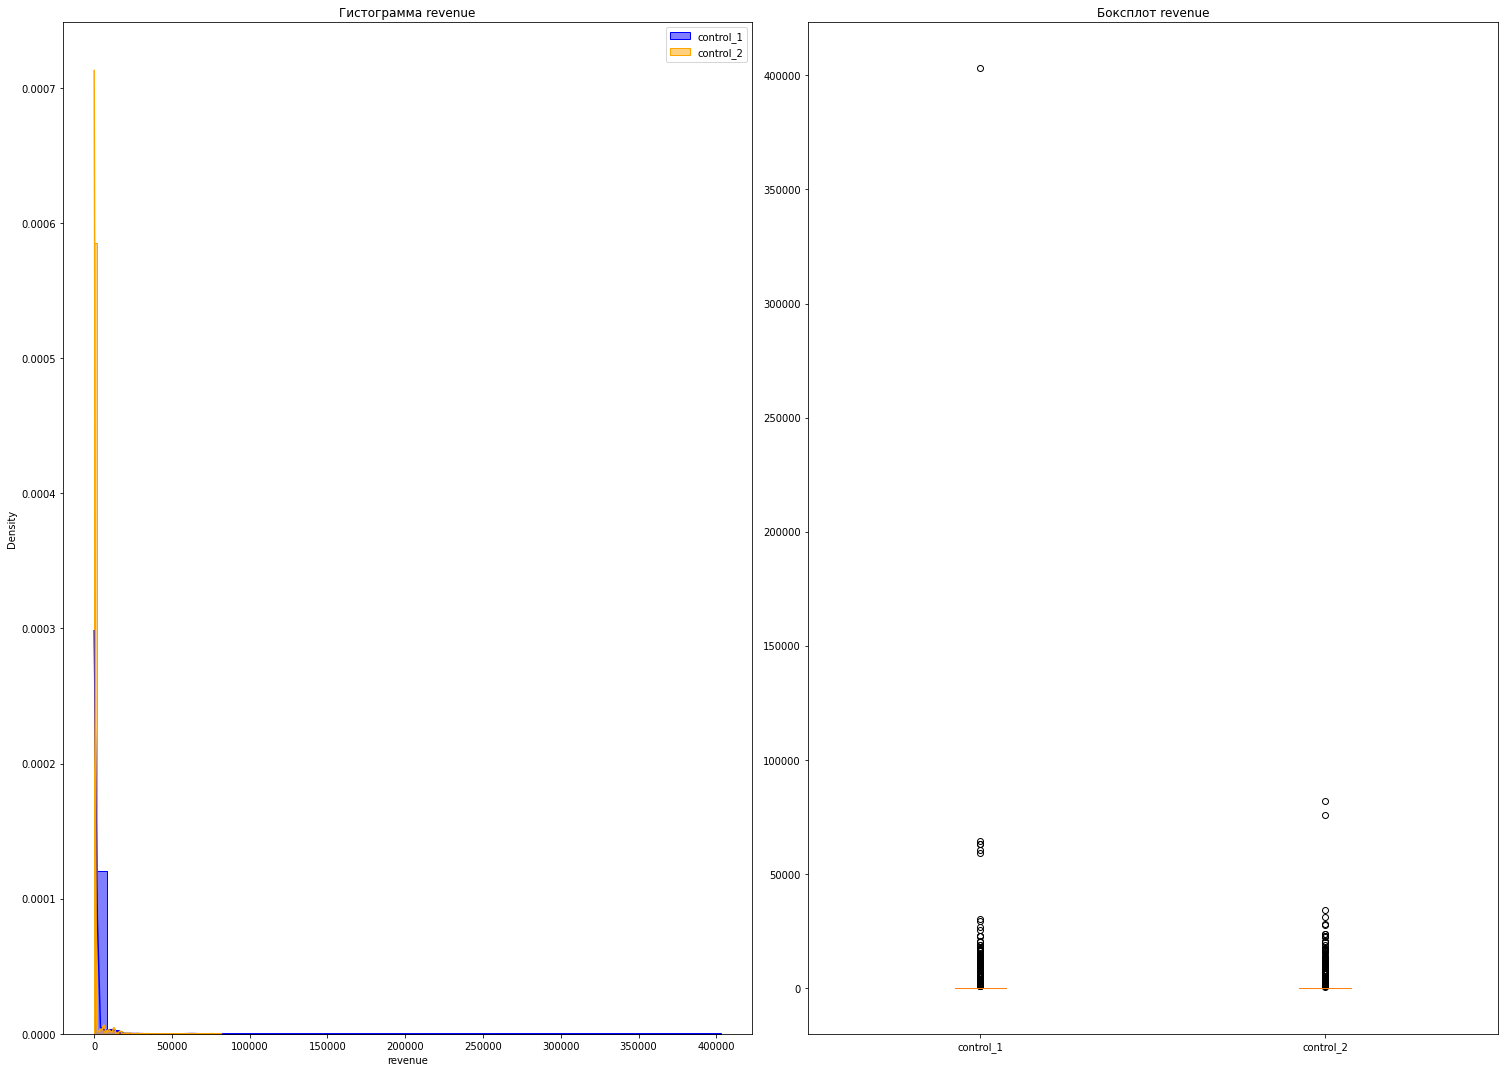

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(21, 15))

# Гистограмма для control_1
sns.histplot(c1_rev['revenue'], bins=50, kde=True, color='blue', label='control_1', ax=axes[0], element='step', stat='density')

# Гистограмма для control_2
sns.histplot(c2_rev['revenue'], bins=50, kde=True, color='orange', label='control_2', ax=axes[0], element='step', stat='density')

axes[0].legend()
axes[0].set_title('Гистограмма revenue')

# Боксплот с двумя раздельными данными
data = np.array([c1_rev['revenue'].dropna(), c2_rev['revenue'].dropna()], dtype=object)
axes[1].boxplot(data, labels=['control_1', 'control_2'])
axes[1].set_title('Боксплот revenue')

plt.tight_layout()
plt.show()

По графикам наблюдаем, что распределения ненормальны и с большими выбросами.  
t-тест Стьюдента использовать не можем, используем Манна-Уитни.

U-тест Манна-Уитни  

**Нулевая гипотеза:** Распределение revenue в группах control_1 и control_2 статистически одинаково, все различия случайны.  
**Альтерантивная гипотеза:** Различия между группами есть.

In [197]:
stat, p = sc.mannwhitneyu(c1_rev['revenue'], c2_rev['revenue'], alternative='two-sided')
print("Revenue statistic:", stat, ", Revenue p-value:", p)

Revenue statistic: 9259640.0 , Revenue p-value: 0.8690780932776594


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, распределение revenue в группах control_1 и control_2 статистически одинаково.

**Проверим CR**

Для сравнения конверсий будем использовать z-тест для разности пропорций.

Z-тест для разности пропорций  

**Нулевая гипотеза:** Конверсия в группах control_1 и control_2 статистически не отличается (пропорции равны).  
**Альтерантивная гипотеза:** Конверсия в группах отличается.

In [198]:
# Найдем кол-во платящих пользователей для каждой из групп
pu_c1 = c1_rev.query('revenue > 0')['uid'].nunique()
pu_c2 = c2_rev.query('revenue > 0')['uid'].nunique()

# Найдем кол-во всех пользователей для каждой из групп
u_c1 = c1_rev['uid'].nunique()
u_c2 = c2_rev['uid'].nunique()

# Z-тест для разности пропорций
pu = [pu_c1, pu_c2]
u = [u_c1, u_c2]

stat, p = proportions_ztest(pu, u)

print("Z-statistic:", stat, ", CR p-value:", p)

Z-statistic: 0.1387075944418351 , CR p-value: 0.8896812166210464


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, конверсия в группах control_1 и control_2 статистически не отличается (пропорции равны).

**Проверим Возраст**

Чтобы понять, какой статистический тест мы можем применить, нам нужно посмотреть распределение age.  
Построим графики распределения age для каждой из групп.

In [199]:
# Возьмём уникальные uid и возраст каждого пользователя
c1_age = control_1.groupby('uid')['age'].first().reset_index()
c2_age = control_2.groupby('uid')['age'].first().reset_index()

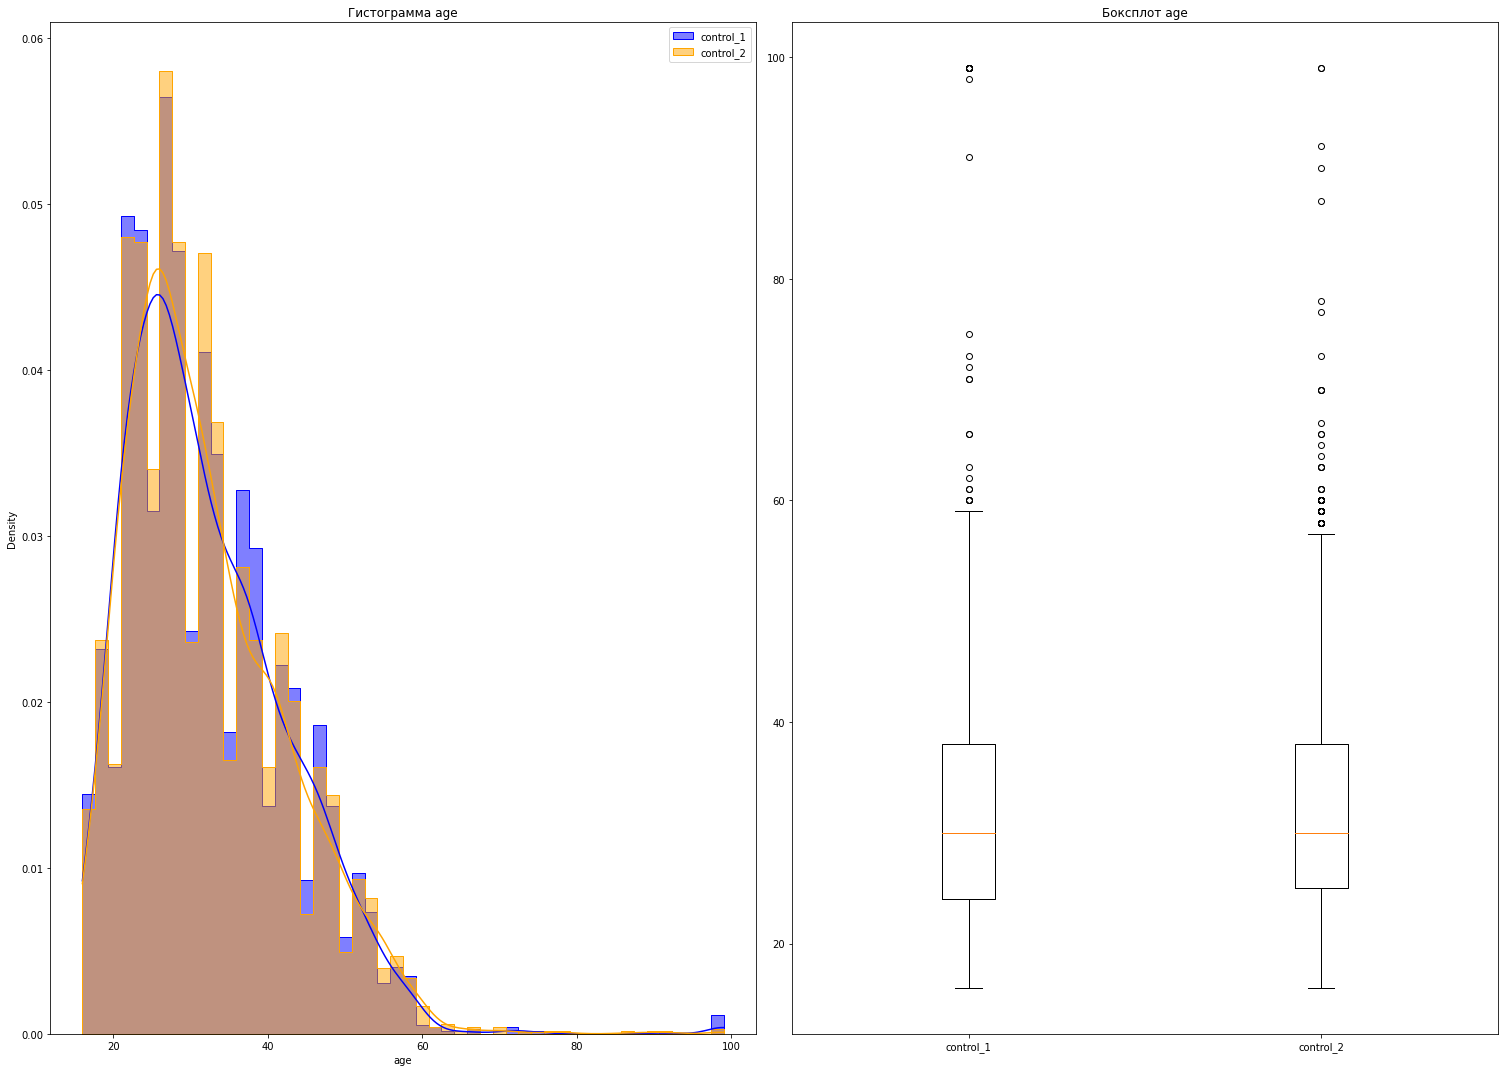

In [200]:
fig, axes = plt.subplots(1, 2, figsize=(21, 15))

# Гистограмма для control_1
sns.histplot(c1_age['age'], bins=50, kde=True, color='blue', label='control_1', ax=axes[0], element='step', stat='density')

# Гистограмма для control_2
sns.histplot(c2_age['age'], bins=50, kde=True, color='orange', label='control_2', ax=axes[0], element='step', stat='density')

axes[0].legend()
axes[0].set_title('Гистограмма age')

# Боксплот с двумя раздельными данными
data = np.array([c1_age['age'].dropna(), c2_age['age'].dropna()], dtype=object)
axes[1].boxplot(data, labels=['control_1', 'control_2'])
axes[1].set_title('Боксплот age')

plt.tight_layout()
plt.show()

По графикам наблюдаем, что распределения ненормальны и с большими выбросами.  
t-тест Стьюдента использовать не можем, используем Манна-Уитни.

U-тест Манна-Уитни  

**Нулевая гипотеза:** Распределение age в группах control_1 и control_2 статистически одинаково, все различия случайны.  
**Альтерантивная гипотеза:** Различия между группами есть.

In [201]:
stat, p = sc.mannwhitneyu(c1_age['age'], c2_age['age'], alternative='two-sided')
print("Age statistic:", stat, ", Age p-value:", p)

Age statistic: 9283252.5 , Age p-value: 0.7919291369256963


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, распределение age в группах control_1 и control_2 статистически одинаково.

**Проверим Страны**

Т.к. столбец состоит из категориальных значений, то будем использовать хи-квадрат тест.

Хи-квадрат тест  

**Нулевая гипотеза:** Распределение по странам в группах control_1 и control_2 статистически одинаково.  
**Альтерантивная гипотеза:** Распределение по странам различно.

In [202]:
# Возьмём страны и кол-во их упоминаний в каждой таблице
c1_country = control_1['country'].value_counts()
c2_country = control_2['country'].value_counts()

# Хи-квадрат тест
contingency_table = pd.DataFrame({'control_1': c1_country, 'control_2': c2_country}).fillna(0).astype(int)
chi2, p, dof, ex = sc.chi2_contingency(contingency_table)
print("Country chi2:", chi2, ", Country p-value:", p)

Country chi2: 64.88697416436803 , Country p-value: 0.2209686430351314


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, распределение по странам в группах control_1 и control_2 статистически одинаково.

**Проверяем Пол**

Т.к. столбец состоит из категориальных бинарных значений, то будем использовать хи-квадрат тест.

Хи-квадрат тест  

**Нулевая гипотеза:** Распределение по полу в группах control_1 и control_2 статистически одинаково.  
**Альтерантивная гипотеза:** Распределение по полу различно.

In [203]:
# Возьмём пол и кол-во их упоминаний в каждой таблице
c1_gender = control_1['gender'].value_counts()
c2_gender = control_2['gender'].value_counts()

# Хи-квадрат тест
contingency_table = pd.DataFrame({'control_1': c1_gender, 'control_2': c2_gender})
chi2, p, dof, ex = sc.chi2_contingency(contingency_table)
print("Country chi2:", chi2, ", Country p-value:", p)

Country chi2: 0.7415790157431776 , Country p-value: 0.3891555321288669


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, распределение по полу в группах control_1 и control_2 статистически одинаково.

**Приходим к выводу, что группы control_1 и control_2 статистически значимо не отличаются друг от друга по ключевым показателям, поэтому мы можем их объединить.**

In [204]:
# Объединяем две группы
control = pd.concat([control_1, control_2], axis=0, ignore_index=True)

control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8903 entries, 0 to 8902
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               8903 non-null   int64         
 1   age               8903 non-null   int64         
 2   attraction_coeff  8903 non-null   int64         
 3   coins             8903 non-null   float64       
 4   country           8903 non-null   object        
 5   visit_days        8903 non-null   object        
 6   gender            8903 non-null   int64         
 7   age_filter_start  8903 non-null   int64         
 8   age_filter_end    8903 non-null   int64         
 9   views_count       8903 non-null   int64         
 10  was_premium       8903 non-null   int64         
 11  is_premium        8903 non-null   int64         
 12  total_revenue     8903 non-null   int64         
 13  visits_count      8903 non-null   int64         
 14  joined_at         679 no

Посчитаем **ARPU** и **CR** для каждой отдельной группы и для объединённой.

In [205]:
# ARPU
с1_arpu = control_1['revenue'].sum() / control_1['uid'].nunique()
с2_arpu = control_2['revenue'].sum() / control_2['uid'].nunique()
control_arpu = control['revenue'].sum() / control['uid'].nunique()

print("ARPU control_1:", с1_arpu)
print("ARPU control_2:", с2_arpu)
print("ARPU control:", control_arpu)

ARPU control_1: 574.8396313364055
ARPU control_2: 447.4664634146341
ARPU control: 511.71559739655976


**ARPU** в объединённой группе получилось примерно средним между двумя отдельными группами.

In [206]:
# CR
c1_cr = control_1.query('revenue > 0')['uid'].nunique() / control_1['uid'].nunique()
c2_cr = control_2.query('revenue > 0')['uid'].nunique() / control_2['uid'].nunique()
control_cr = control.query('revenue > 0')['uid'].nunique() / control['uid'].nunique()

print("CR control_1:", c1_cr)
print("CR control_2:", c2_cr)
print("CR control:", control_cr)

CR control_1: 0.044470046082949306
CR control_2: 0.04385553470919325
CR control: 0.04416550441655044


**CR** в объединённой группе получилось примерно средним между двумя отдельными группами.

Теперь у нас есть две группы (тестовая и контрольная), с которыми мы можем дальше работать.  
Но прежде, чем перейти к сравнению этих групп, вспомним условие нашей задачи:  
"Был проведен A/B тест, в рамках которого для **новых пользователей** из **нескольких стран** была изменена стоимость **премиум-подписки** при покупке через **две новые платежные системы**. **При этом стоимость пробного периода оставалась прежней.**".  
Что нам нужно сделать для начала:
1. Проверить, а действительно ли у нас все пользователи новые? Если все новые, то скорее всего значения в столбце joined_at будут в каких-то общих рамках. Нужно посмотреть, не выделяется ли кто-нибудь из этого списка.
2. Посмотреть есть ли не общие страны у наших двух групп, думаю, что в них нет смысла и возможно их нужно убрать.
3. Указано, что была изменена стоимость подписки именно premium_no_trial, нужно это учесть.
4. Изменена стоимость при покупке через две новые платёжные системы, нужно попробовать определить, через какие.

**Проверим, есть ли в наших данных пользователи, выходящие за временные рамки регистрации**

In [207]:
# Посмотрим временные рамки регистрации пользователей в таблице test
test.joined_at.min().strftime('%Y.%m.%d'), test.joined_at.max().strftime('%Y.%m.%d')

('2017.01.11', '2017.10.31')

In [208]:
# Посмотрим временные рамки регистрации пользователей в таблице control
control.joined_at.min().strftime('%Y.%m.%d'), control.joined_at.max().strftime('%Y.%m.%d')

('2015.01.19', '2017.10.31')

Видно, что в таблице control, есть пользователи, которые зарегистрировались раньше, чем пользователи в группе test.  
Найдём этих пользователей.

In [209]:
control.query('joined_at < @test.joined_at.min().date()')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visits_count,joined_at,paid_at,revenue,payment_id,from_page,product_type
522,960936960,30,4,99958.0,Russian Federation,"[1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, ...",1,26,62,4262,1,1,26,27,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
523,960936960,30,4,99958.0,Russian Federation,"[1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, ...",1,26,62,4262,1,1,26,27,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
524,960936960,30,4,99958.0,Russian Federation,"[1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, ...",1,26,62,4262,1,1,26,27,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


Это один единственный пользователь с uid - 960936960, видимо попал сюда по ошибке.  
Уберём эти лишние данные из таблицы control.

In [210]:
drop_ids = control.query('uid == 960936960').index
control = control.drop(drop_ids)

In [211]:
# Проверим временные рамки регистрации пользователей в таблице control ещё раз
control.joined_at.min().strftime('%Y.%m.%d'), control.joined_at.max().strftime('%Y.%m.%d')

('2017.01.11', '2017.10.31')

**Теперь проведём анализ стран в наших таблицах.**

In [212]:
# Найдём уникальные страны в каждой таблице
test_countries = set(test['country'].unique())
control_countries = set(control['country'].unique())

# Общее количество стран
total_countries_test = len(test_countries)
total_countries_control = len(control_countries)

# Найдём кол-во пересекающихся стран и сделаем список этих стран
intersect_countries = test_countries.intersection(control_countries)
count_intersect = len(intersect_countries)
list_intersect = list(intersect_countries)

# Найдём уникальные страны для каждой таблицы
unique_to_test = test_countries - control_countries
unique_to_control = control_countries - test_countries

# Найдём кол-во уникальных стран для каждой таблицы
count_unique_to_test = len(unique_to_test)
count_unique_to_control = len(unique_to_control)

print(f"Кол-во стран в test: {total_countries_test}")
print(f"Кол-во стран в control: {total_countries_control}")
print(f"Кол-во стран, пересекающихся в обеих группах: {count_intersect}")
print()
print(f"Пересекающиеся страны: {list_intersect}")
print()
print(f"Кол-во уникальных стран в test: {count_unique_to_test}")
print(f"Кол-во уникальных стран в control: {count_unique_to_control}")
print()
print(f"Список уникальных стран в test: {unique_to_test}")
print()
print(f"Список уникальных стран в control: {unique_to_control}")

Кол-во стран в test: 51
Кол-во стран в control: 58
Кол-во стран, пересекающихся в обеих группах: 37

Пересекающиеся страны: ['Canada', 'Romania', 'Mexico', 'Switzerland', 'United States of America', 'Portugal', 'Colombia', 'Italy', 'Kyrgyzstan', 'Pakistan', 'Argentina', 'Chile', 'Tunisia', 'Uruguay', 'Puerto Rico', 'Georgia', 'Russian Federation', 'United Arab Emirates', 'Ukraine', 'Germany', 'Australia', 'Costa Rica', 'Belgium', 'Algeria', 'Spain', 'Hungary', 'Egypt', 'Morocco', 'India', 'Peru', 'Turkey', 'Philippines', 'Dominican Republic', 'Israel', 'France', 'United Kingdom (Great Britain)', 'Tajikistan']

Кол-во уникальных стран в test: 14
Кол-во уникальных стран в control: 21

Список уникальных стран в test: {'Monaco', 'Nepal', 'Gambia', 'Guatemala', 'Brazil', 'Korea, Republic of', 'Latvia', 'Singapore', 'Indonesia', 'Uzbekistan', 'Bolivia', 'Azerbaijan', 'Islamic Republic of Iran', 'Iraq'}

Список уникальных стран в control: {'China', 'Moldova, Republic of', 'Armenia', 'Mali', '

In [213]:
# Посмотрим на пользователей с уникальными странами в test
unique_rows_test = test[test['country'].isin(unique_to_test)]

# Посчитаем какую долю от общего кол-ва пользователей составляяют эти пользователи
unique_country_test_user_part = round((unique_rows_test['uid'].nunique() / test['uid'].nunique()) * 100, 2)

# Посмотрим какую долю от общего revenue составляет revenue этих пользователи
unique_country_test_revenue_part = round((unique_rows_test['revenue'].sum() / test['revenue'].sum()) * 100, 2)

print(f"Доля пользователей с уникальными странами в test: {unique_country_test_user_part} %")
print()
print(f"Доля revenue пользователей с уникальными странами в test: {unique_country_test_revenue_part} %")

Доля пользователей с уникальными странами в test: 0.42 %

Доля revenue пользователей с уникальными странами в test: 0.39 %


Как мы видим эти пользователи занимают незначительную долю в таблице test, можно оставить, на анализ не должны особо повлиять.

In [214]:
# Посмотрим на пользователей с уникальными странами в control
unique_rows_control = control[control['country'].isin(unique_to_control)]

# Посчитаем какую долю от общего кол-ва пользователей составляяют эти пользователи
unique_country_control_user_part = round((unique_rows_control['uid'].nunique() / test['uid'].nunique()) * 100, 2)

# Посмотрим какую долю от общего revenue составляет revenue этих пользователи
unique_country_control_revenue_part = round((unique_rows_control['revenue'].sum() / test['revenue'].sum()) * 100, 2)

print(f"Доля пользователей с уникальными странами в control: {unique_country_control_user_part} %")
print()
print(f"Доля revenue пользователей с уникальными странами в control: {unique_country_control_revenue_part} %")

Доля пользователей с уникальными странами в control: 0.58 %

Доля revenue пользователей с уникальными странами в control: 1.07 %


Как мы видим эти пользователи занимают незначительную долю в таблице control, можно оставить, на анализ не должны особо повлиять.

## Сравнителный анализ тестовой и контрольной группы.

Для начала проверим насколько наши группы сопоставимы, то есть не имеют статистически значимых различий по базовым демографическим метрикам. Если группы отличаются — результаты теста будут искажены.
Основные параметры, по которым будем проверять:
1. Возраст
2. Страна
3. Пол

**Проверим Возраст**

Чтобы понять, какой статистический тест мы можем применить, нам нужно посмотреть распределение age.  
Построим графики распределения age для каждой из групп.

In [215]:
# Возьмём уникальные uid и возраст каждого пользователя
test_age = test.groupby('uid')['age'].first().reset_index()
control_age = control.groupby('uid')['age'].first().reset_index()

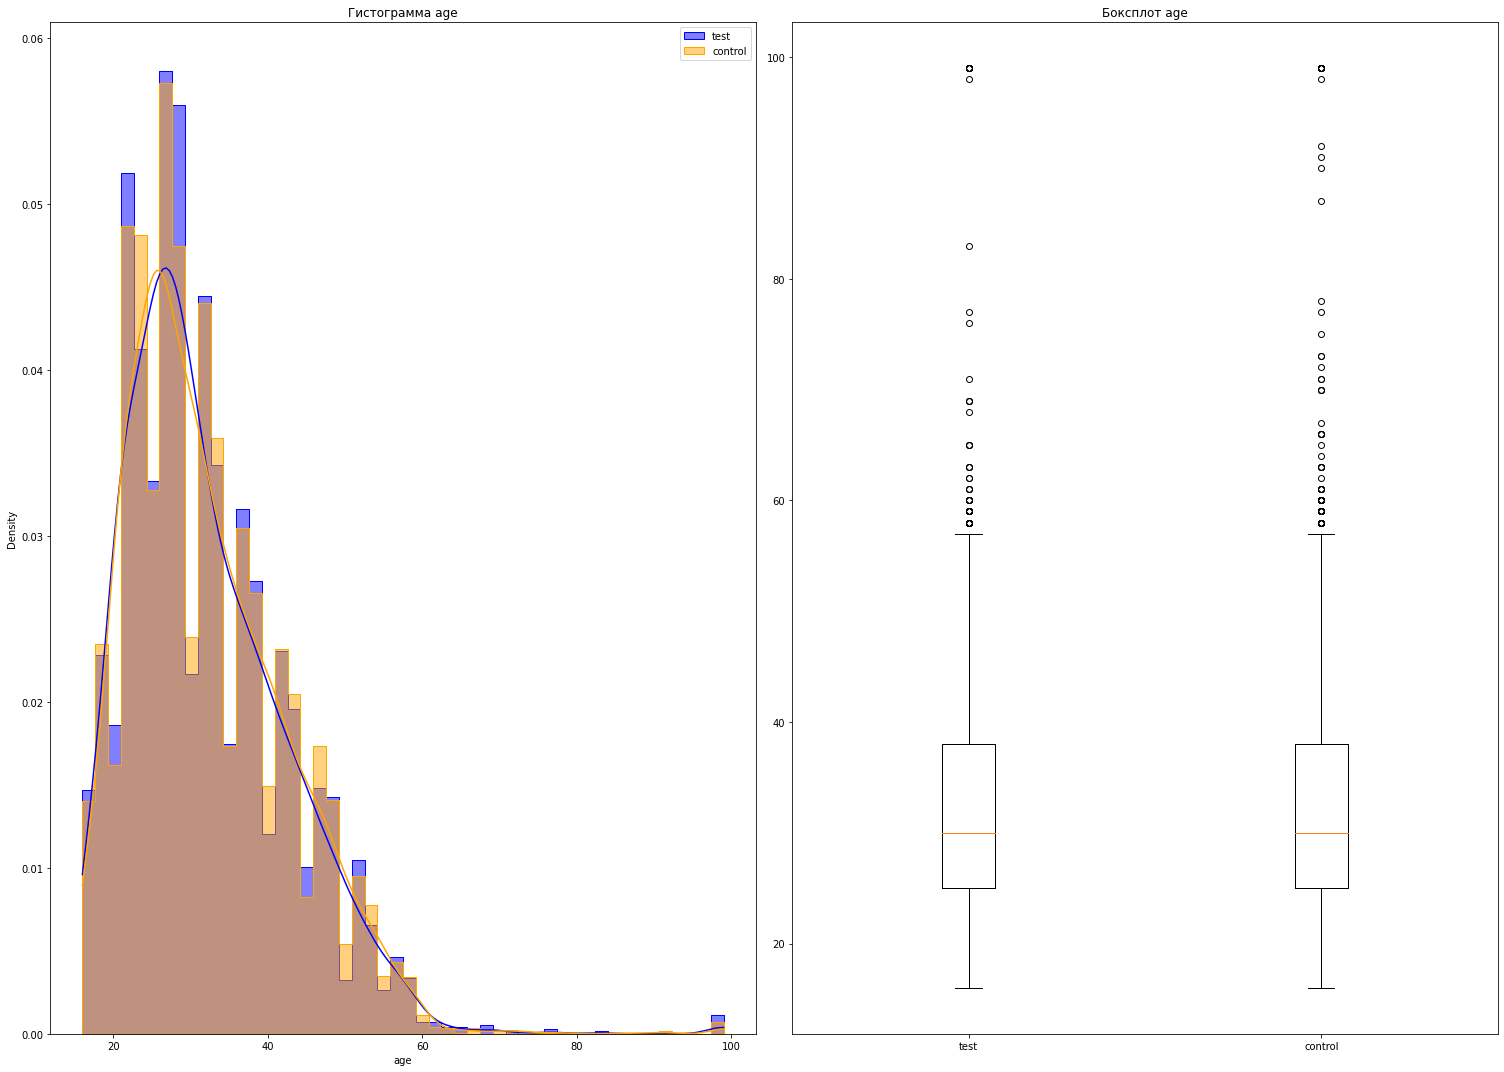

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(21, 15))

# Гистограмма для test
sns.histplot(test_age['age'], bins=50, kde=True, color='blue', label='test', ax=axes[0], element='step', stat='density')

# Гистограмма для control
sns.histplot(control_age['age'], bins=50, kde=True, color='orange', label='control', ax=axes[0], element='step', stat='density')

axes[0].legend()
axes[0].set_title('Гистограмма age')

# Боксплот с двумя раздельными данными
data = np.array([test_age['age'].dropna(), control_age['age'].dropna()], dtype=object)
axes[1].boxplot(data, labels=['test', 'control'])
axes[1].set_title('Боксплот age')

plt.tight_layout()
plt.show()

По графикам наблюдаем, что распределения ненормальны и с большими выбросами.  
t-тест Стьюдента использовать не можем, используем Манна-Уитни.

U-тест Манна-Уитни  

**Нулевая гипотеза:** Распределение age в группах test и control статистически одинаково, все различия случайны.  
**Альтерантивная гипотеза:** Различия между группами есть.

In [217]:
stat, p = sc.mannwhitneyu(test_age['age'], control_age['age'], alternative='two-sided')
print("Age statistic:", stat, ", Age p-value:", p)

Age statistic: 18327535.0 , Age p-value: 0.30831022190854684


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, распределение age в группах test и control статистически одинаково.

**Проверим Страны**

Т.к. столбец состоит из категориальных значений, то будем использовать хи-квадрат тест.

Хи-квадрат тест  

**Нулевая гипотеза:** Распределение по странам в группах test и control статистически одинаково.  
**Альтерантивная гипотеза:** Распределение по странам различно.

In [218]:
# Возьмём страны и кол-во их упоминаний в каждой таблице
test_country = test['country'].value_counts()
control_country = control['country'].value_counts()

# Хи-квадрат тест
contingency_table = pd.DataFrame({'test': test_country, 'control': control_country}).fillna(0).astype(int)
chi2, p, dof, ex = sc.chi2_contingency(contingency_table)
print("Country chi2:", chi2, ", Country p-value:", p)

Country chi2: 70.7055311733182 , Country p-value: 0.4875324372828487


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, распределение по странам в группах test и control статистически одинаково.

**Проверяем Пол**

Т.к. столбец состоит из категориальных бинарных значений, то будем использовать хи-квадрат тест.

Хи-квадрат тест  

**Нулевая гипотеза:** Распределение по полу в группах test и control статистически одинаково.  
**Альтерантивная гипотеза:** Распределение по полу различно.

In [219]:
# Возьмём пол и кол-во их упоминаний в каждой таблице
test_gender = test['gender'].value_counts()
control_gender = control['gender'].value_counts()

# Хи-квадрат тест
contingency_table = pd.DataFrame({'test': test_gender, 'control': control_gender})
chi2, p, dof, ex = sc.chi2_contingency(contingency_table)
print("Country chi2:", chi2, ", Country p-value:", p)

Country chi2: 0.6794611342978345 , Country p-value: 0.40977234234109006


Получаем p-value > 0.05, нулевую гипотезу не отклоняем, распределение по полу в группах test и control статистически одинаково.

**Группы test и control не имеют статистически значимых различий по ключевым демографическим признакам, что обеспечивает корректность нашего дальнейшего анализа.**

Посчитаем **ARPU** для каждой группы.

In [220]:
# ARPU для test
test_arpu = test['revenue'].sum() / test['uid'].nunique()

# ARPU для control
control_arpu = control['revenue'].sum() / control['uid'].nunique()

print(f"ARPU в test: {test_arpu}")
print()
print(f"ARPU в control: {control_arpu}")

ARPU в test: 541.3709377901579

ARPU в control: 511.6813902127165


ARPU в группе test больше, чем в группе control, но нужно проверить, что это статистически значимое различие, может быть это просто случайность.  
Для проверки нам нужно выбрать подходящий тест, поэтому посмотрим на распределение revenue в группах и решим какой тест будем использовать.

In [221]:
# Сначала сгруппируем данные по uid и просуммируем revenue для каждого пользователя
test_rev = test.groupby('uid', as_index = False).agg({'revenue': 'sum'})
control_rev = control.groupby('uid', as_index = False).agg({'revenue': 'sum'})

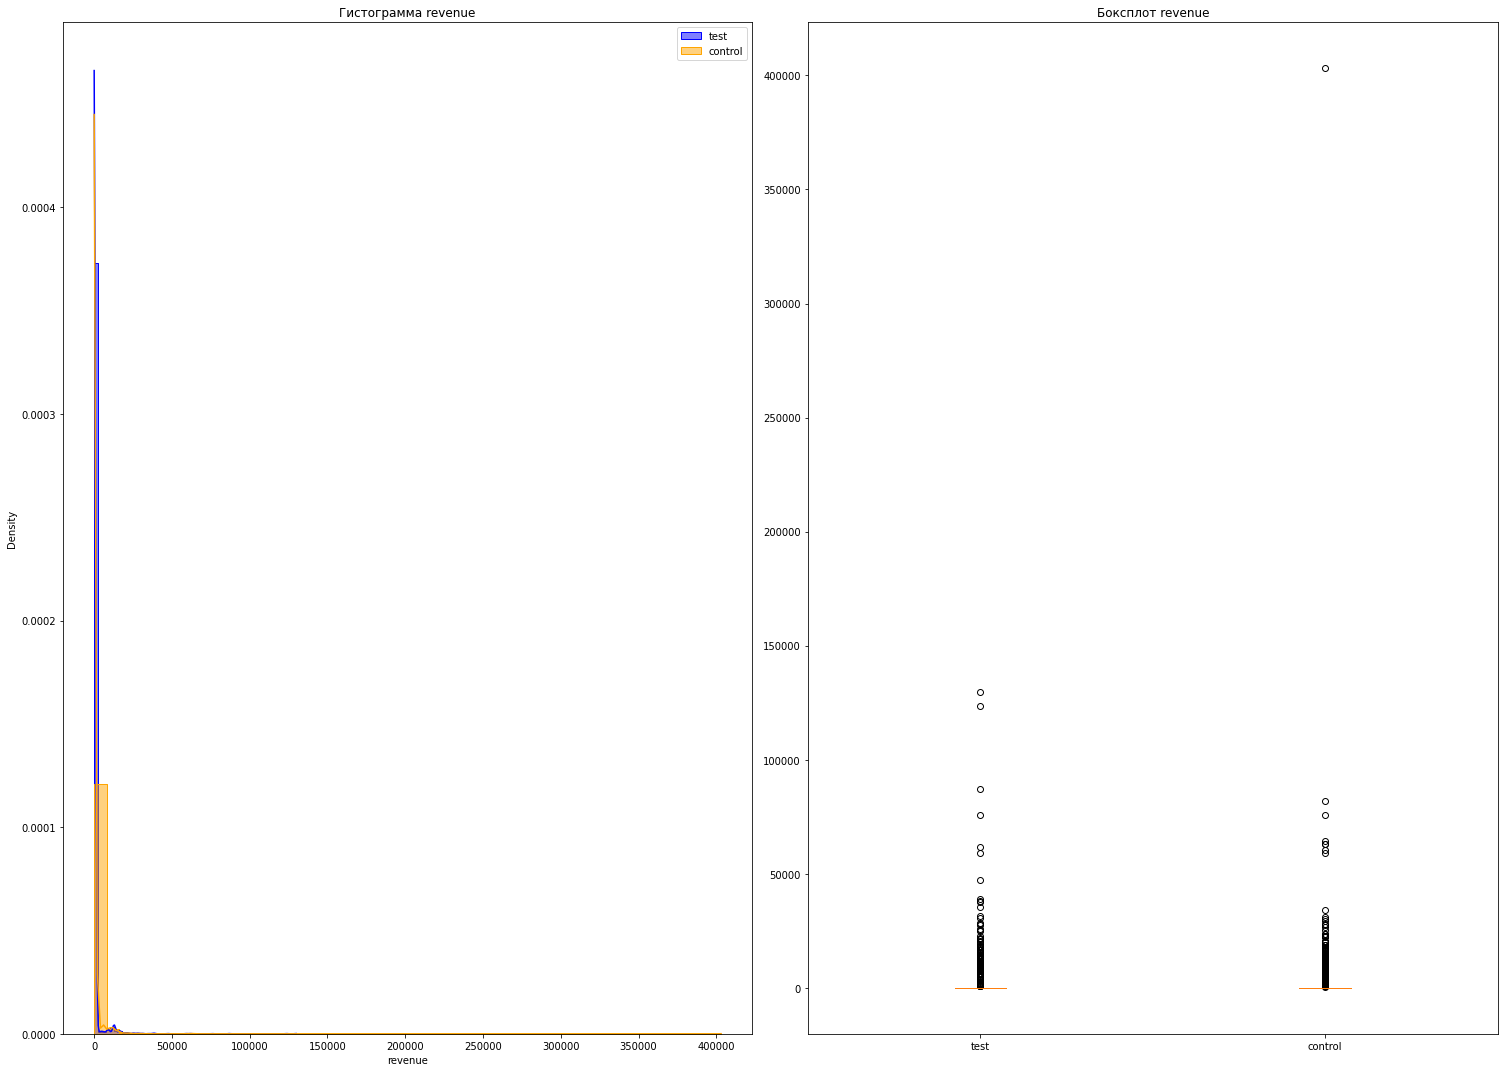

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(21, 15))

# Гистограмма для test
sns.histplot(test_rev['revenue'], bins=50, kde=True, color='blue', label='test', ax=axes[0], element='step', stat='density')

# Гистограмма для control
sns.histplot(control_rev['revenue'], bins=50, kde=True, color='orange', label='control', ax=axes[0], element='step', stat='density')

axes[0].legend()
axes[0].set_title('Гистограмма revenue')

# Боксплот с двумя раздельными данными
data = np.array([test_rev['revenue'].dropna(), control_rev['revenue'].dropna()], dtype=object)
axes[1].boxplot(data, labels=['test', 'control'])
axes[1].set_title('Боксплот revenue')

plt.tight_layout()
plt.show()

По графикам наблюдаем, что распределения далеки от нормальных и содержат много выбросов. 
  
t-тест Стьюдента использовать не можем. Непараметрический U-тест Манна-Уитни сравнивает распределения (ранги) двух групп и не является тестом именно на разницу средних значений. В нашей задаче нас интересует статистическая значимость разницы средних доходов на пользователя, поэтому критерий Манна–Уитни не даёт корректного результата как «средний доход изменился».  
  
Попробуем использовать bootstrap доверительного интервала для разницы средних.

Bootstrap 

**Нулевая гипотеза:** Средние значения ARPU в группах test и control статистически не различаются.  
**Альтерантивная гипотеза:** Средние значения различаются.  

Если ноль лежит вне доверительного интервала, то это означает, что с заданной уверенностью (95%) нулевая гипотеза отвергается и изменения считаются статистически значимыми.

In [223]:
# Преобразуем наши столбцы revenue в обоих группах в массивы
arr_rev_test = np.array(test_rev['revenue'])
arr_rev_control = np.array(control_rev['revenue'])

# Функция для вычисления разницы средних (ARPU test - ARPU control)
def diff_mean(x, y, axis = 0):
    return np.mean(y, axis = axis) - np.mean(x, axis = axis)

data = (arr_rev_control, arr_rev_test)

# Запуск бутстрапа для оценки доверительного интервала разницы средних
res = sc.bootstrap(data, statistic = diff_mean, confidence_level = 0.95, n_resamples = 9999, method = 'percentile', vectorized = False)

# Вывод результатов
print(f"Доверительный интервал разницы средних (ARPU test - ARPU control): {res.confidence_interval}")

Доверительный интервал разницы средних (ARPU test - ARPU control): ConfidenceInterval(low=-150.05750235741863, high=203.85447735917506)


Ноль лежит в доверительном интервале, это означает, что мы не можем отклонить нулевую гипотезу, а значит **средние значения ARPU в группах test и control статистически не различаются**.

Прежде чем переходить к подсчёту **CR** и **ARPPU**, вспомним оставшиеся условия задачи: 
1. Было указано, что была изменена стоимость подписки именно premium_no_trial.
2. Была изменена стоимость при покупке через две новые платёжные системы. 

Попробуем выяснить, какие две новые платежные системы это могли быть.

In [224]:
# Отсортируем группу test по условию product_type == premium_no_trial
test_prem_no_trial = test.query('product_type == "premium_no_trial"')

# Посмотрим на payment_id отфильтрованной таблицы
test_prem_no_trial['payment_id'].value_counts()

147.0    63
68.0     12
0.0       1
Name: payment_id, dtype: int64

In [225]:
# Отсортируем группу control по условию product_type == premium_no_trial
control_prem_no_trial = control.query('product_type == "premium_no_trial"')

# Посмотрим на payment_id отфильтрованной таблицы
control_prem_no_trial['payment_id'].value_counts()

147.0    180
68.0      30
0.0        3
Name: payment_id, dtype: int64

Приходим к выводу, что скорее всегго это платежные инструменты "147" и "68", т.к. больше всего было платежей через эти системы в обеих группах.

In [226]:
# Уберём платежный инструмент "0" из наших таблиц и получаем группы, которые нам интересны в рамках A/B теста
test_prem_no_trial = test_prem_no_trial.query('payment_id != 0')
control_prem_no_trial = control_prem_no_trial.query('payment_id != 0')

Посчитаем **CR** для каждой группы.

In [227]:
# CR для группы test
CR_test = round((test_prem_no_trial['uid'].nunique() / test['uid'].nunique()) * 100, 2)

# CR для группы control
CR_control = round((control_prem_no_trial['uid'].nunique() / control['uid'].nunique()) * 100, 2)

print(f"CR в test: {CR_test} %")
print()
print(f"CR в control: {CR_control} %")

CR в test: 1.56 %

CR в control: 2.34 %


Конверсия в группе control больше, чем в группе test, но нужно проверить, что это статистически значимое различие, может быть это просто случайность.

Для сравнения конверсий будем использовать z-тест для разности пропорций.

Z-тест для разности пропорций  

**Нулевая гипотеза:** Конверсия в группах test и control статистически не отличается (пропорции равны).  
**Альтерантивная гипотеза:** Конверсия в группах отличается.

In [228]:
# Rол-во платящих пользователей для каждой из групп
pu_test = test_prem_no_trial['uid'].nunique()
pu_control = control_prem_no_trial['uid'].nunique()

# Кол-во всех пользователей для каждой из групп
u_test = test['uid'].nunique()
u_control = control['uid'].nunique()

# Z-тест для разности пропорций
pu = [pu_test, pu_control]
u = [u_test, u_control]

stat, p = proportions_ztest(pu, u)

print("Z-statistic:", stat, ", CR p-value:", p)

Z-statistic: -2.9355111535355274 , CR p-value: 0.003329986397413261


Получаем p-value < 0.05, нулевую гипотезу отклоняем, конверсия в группах test и control статистически различна.

Посчитаем **ARPPU** для каждой группы.

In [229]:
# ARPPU для test
test_arppu = test_prem_no_trial['revenue'].sum() / test_prem_no_trial['uid'].nunique()

# ARPPU для control
control_arppu = control_prem_no_trial['revenue'].sum() / control_prem_no_trial['uid'].nunique()

print(f"ARPPU в test: {test_arppu}")
print()
print(f"ARPPU в control: {control_arppu}")

ARPPU в test: 11962.522388059702

ARPPU в control: 7495.6965174129355


ARPPU в группе test больше, чем в группе control, но нужно проверить, что это статистически значимое различие, может быть это просто случайность.
Для проверки нам нужно выбрать подходящий тест, поэтому посмотрим на распределение revenue в **отфильтрованных группах** и решим какой тест будем использовать.

In [230]:
# Сначала сгруппируем данные по uid и просуммируем revenue для каждого пользователя
test_prem_no_trial_rev = test_prem_no_trial.groupby('uid', as_index = False).agg({'revenue': 'sum'})
control_prem_no_trial_rev = control_prem_no_trial.groupby('uid', as_index = False).agg({'revenue': 'sum'})

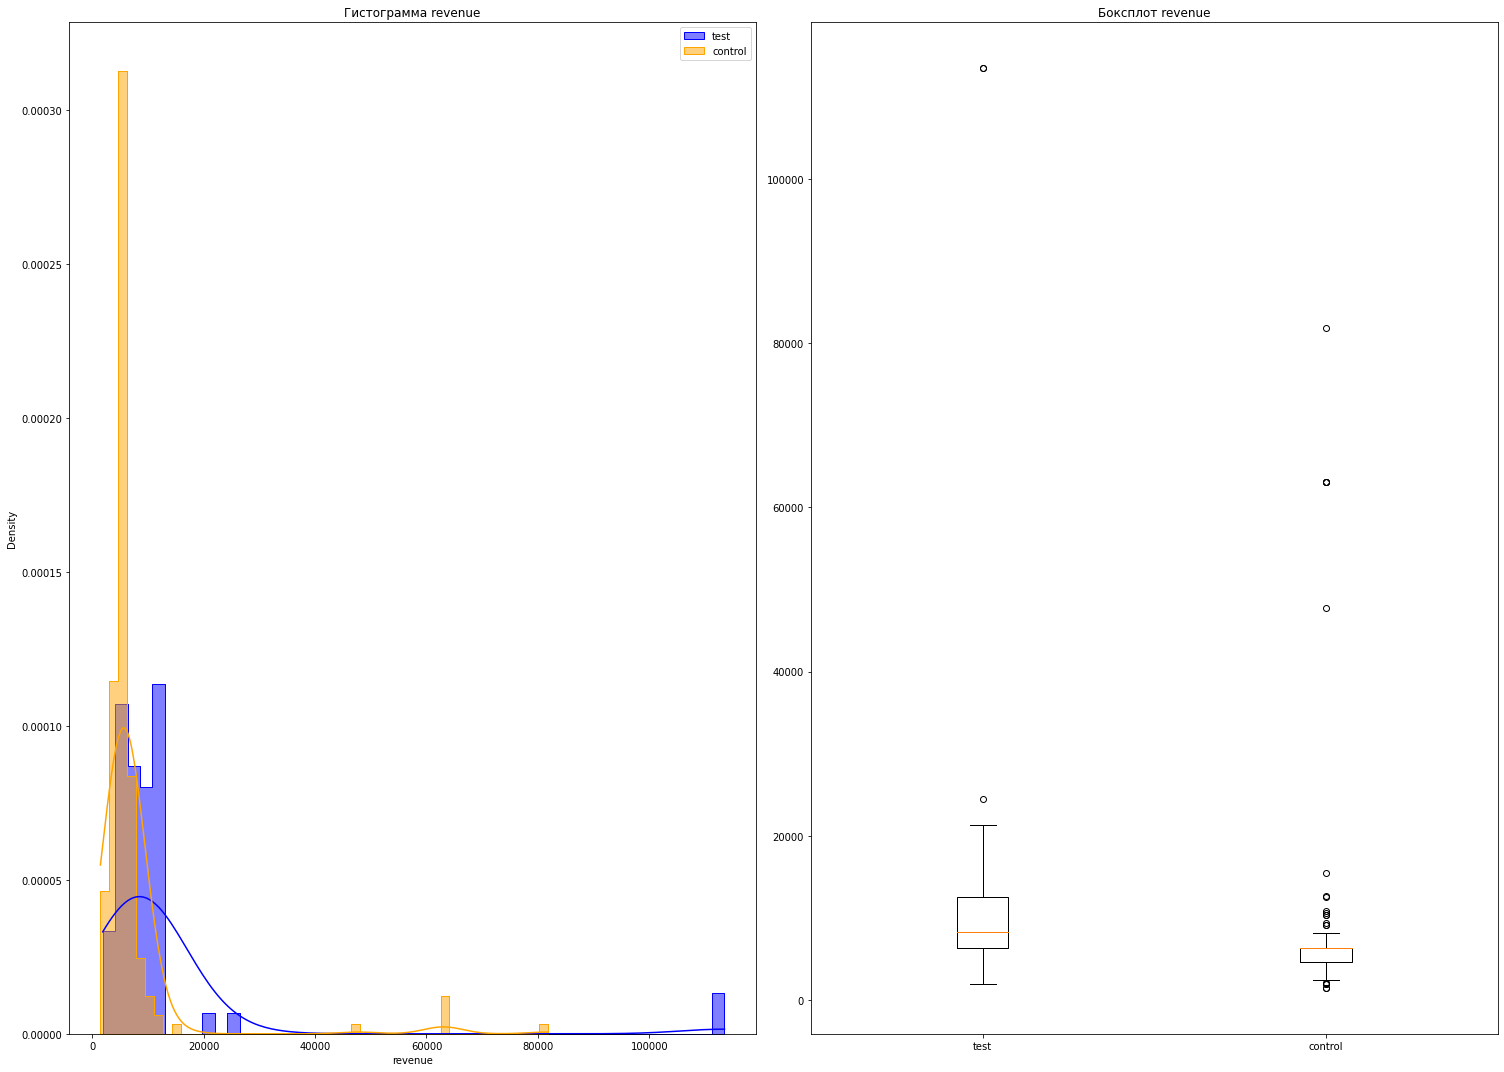

In [231]:
fig, axes = plt.subplots(1, 2, figsize=(21, 15))

# Гистограмма для test
sns.histplot(test_prem_no_trial_rev['revenue'], bins=50, kde=True, color='blue', label='test', ax=axes[0], element='step', stat='density')

# Гистограмма для control
sns.histplot(control_prem_no_trial_rev['revenue'], bins=50, kde=True, color='orange', label='control', ax=axes[0], element='step', stat='density')

axes[0].legend()
axes[0].set_title('Гистограмма revenue')

# Боксплот с двумя раздельными данными
data = np.array([test_prem_no_trial_rev['revenue'].dropna(), control_prem_no_trial_rev['revenue'].dropna()], dtype=object)
axes[1].boxplot(data, labels=['test', 'control'])
axes[1].set_title('Боксплот revenue')

plt.tight_layout()
plt.show()

По графикам наблюдаем, что распределения далеки от нормальных и содержат много выбросов. 
  
t-тест Стьюдента использовать не можем. Непараметрический U-тест Манна-Уитни сравнивает распределения (ранги) двух групп и не является тестом именно на разницу средних значений. В нашей задаче нас интересует статистическая значимость разницы средних доходов на пользователя, поэтому критерий Манна–Уитни не даёт корректного результата как «средний доход изменился».  
  
Попробуем использовать bootstrap доверительного интервала для разницы средних.

Bootstrap 

**Нулевая гипотеза:** Средние значения ARPPU в отфильтрованных группах test и control статистически не различаются.  
**Альтерантивная гипотеза:** Средние значения различаются.  

Если ноль лежит вне доверительного интервала, то это означает, что с заданной уверенностью (95%) нулевая гипотеза отвергается и изменения считаются статистически значимыми.

In [232]:
# Преобразуем наши столбцы revenue в обоих группах в массивы
arr_rev_test_prem_no_trial = np.array(test_prem_no_trial_rev['revenue'])
arr_rev_control_prem_no_trial = np.array(control_prem_no_trial_rev['revenue'])

# Функция для вычисления разницы средних (ARPPU test - ARPPU control)
def diff_mean(x, y, axis = 0):
    return np.mean(y, axis = axis) - np.mean(x, axis = axis)

data = (arr_rev_control_prem_no_trial, arr_rev_test_prem_no_trial)

# Запуск бутстрапа для оценки доверительного интервала разницы средних
res = sc.bootstrap(data, statistic = diff_mean, confidence_level = 0.95, n_resamples = 9999, method = 'percentile', vectorized = False)

# Вывод результатов
print(f"Доверительный интервал разницы средних (ARPPU test - ARPPU control): {res.confidence_interval}")

Доверительный интервал разницы средних (ARPPU test - ARPPU control): ConfidenceInterval(low=503.96019900497583, high=9721.14452736318)


Ноль не лежит в доверительном интервале, это означает, что мы можем отклонить нулевую гипотезу, а значит **средние значения ARPPU в отфильтрованных группах test и control статистически различаются**.

## Промежуточный вывод

**ARPU** немного вырос, но этот рост статистически не значим.  
**CR** в контрольной группе и так не была большой (всего 2,34 %) в тестовой группе упала до 1,56 % (падение на 0,78 %).  
**ARPPU** статистически значимо вырос с 7495 в контрольной группе до 11962 в тестовой группе (прирост в 59%), т.е. люди с премиумом начали платить больше за подписку. 

## Попробуем посмотреть на наши метрики без выбросов

Для **ARPU** мы не будем убирать выбросы, т.к. эту метрику считают по всей аудитории, включая тех, кто не платит. Если убрать все большие платежи — средний доход станет почти нулём, и это не покажет реальную картину.  

Для **CR** и **ARPPU** логично убрать выбросы, чтобы не дать очень большим покупкам «перекосить» результаты и понять, как пользователи в среднем себя ведут.

Для фильтрации выбросов в revenue попробуем метод межквартильного размаха (IQR).

In [233]:
# Фильтруем в группе test
Q1_t = test_prem_no_trial_rev['revenue'].quantile(0.25)
Q3_t = test_prem_no_trial_rev['revenue'].quantile(0.75)
IQR_t = Q3_t - Q1_t
lower_bound_t = Q1_t - 1.5 * IQR_t
upper_bound_t = Q3_t + 1.5 * IQR_t

test_prem_no_trial_f = test_prem_no_trial_rev[(test_prem_no_trial_rev['revenue'] >= lower_bound_t) & (test_prem_no_trial_rev['revenue'] <= upper_bound_t)]

In [234]:
# Фильтруем в группе control
Q1_c = control_prem_no_trial_rev['revenue'].quantile(0.25)
Q3_c = control_prem_no_trial_rev['revenue'].quantile(0.75)
IQR_c = Q3_c - Q1_c
lower_bound_c = Q1_c - 1.5 * IQR_c
upper_bound_c = Q3_c + 1.5 * IQR_c

control_prem_no_trial_f = control_prem_no_trial_rev[(control_prem_no_trial_rev['revenue'] >= lower_bound_c) & (control_prem_no_trial_rev['revenue'] <= upper_bound_c)]

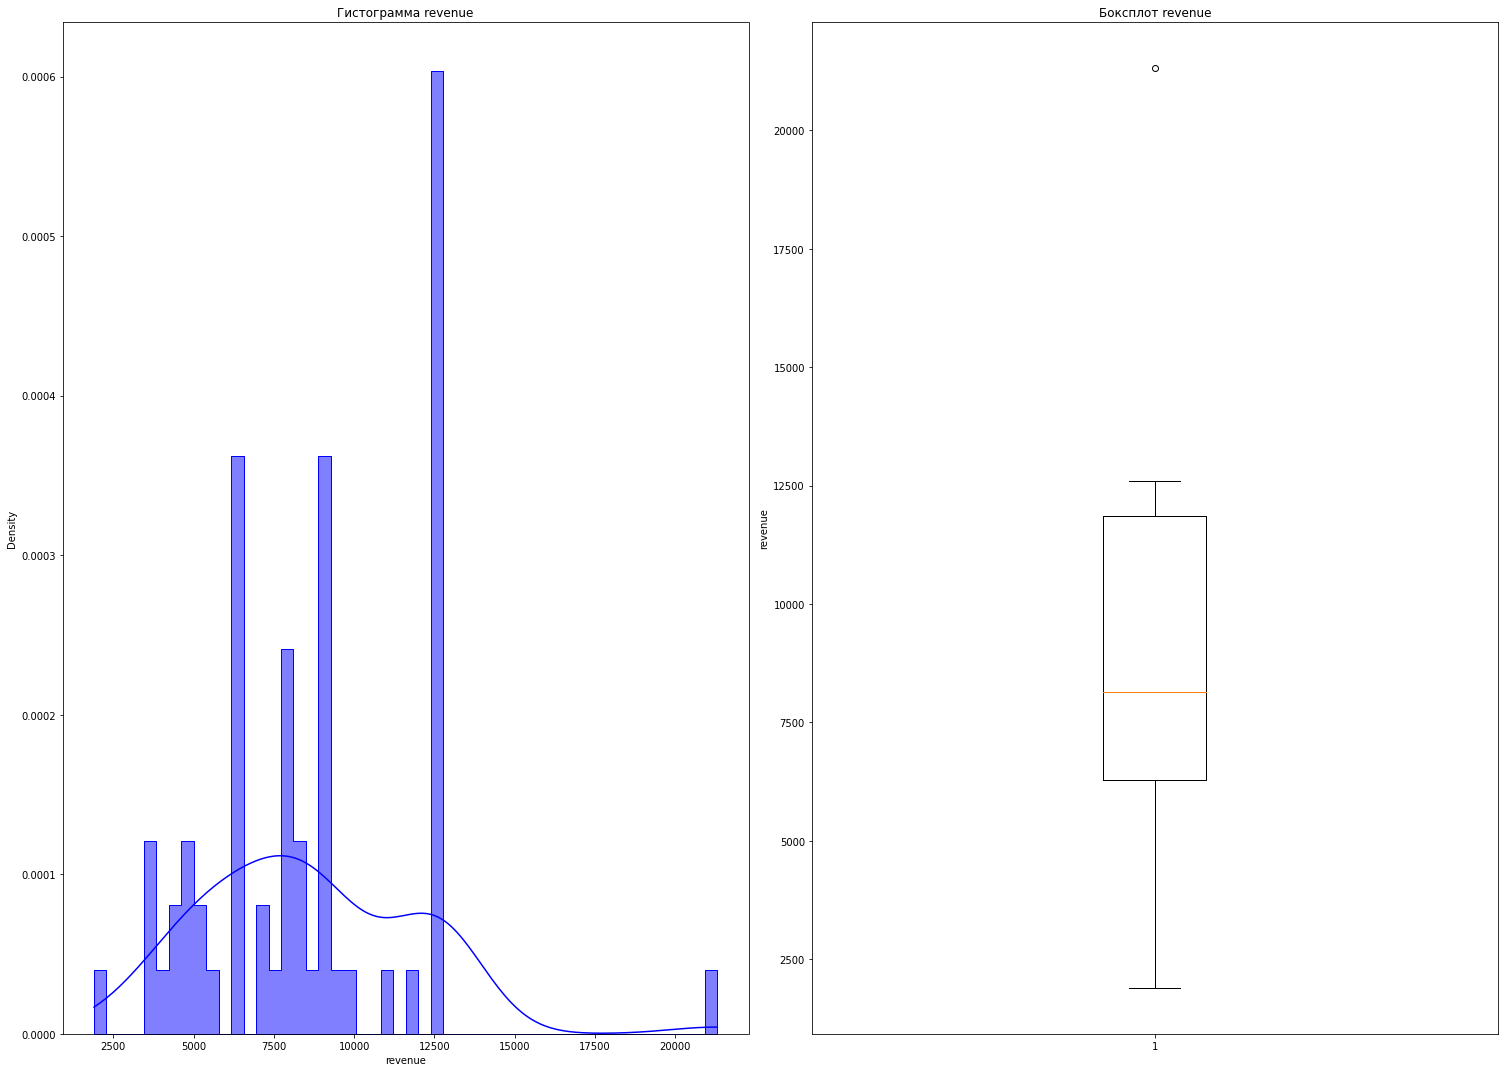

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(21, 15))

# Гистограмма revenue для test
sns.histplot(data=test_prem_no_trial_f['revenue'], bins=50, kde=True, color='blue', ax=axes[0], element='step', stat='density')
axes[0].set_title('Гистограмма revenue')

# Боксплот для test
axes[1].boxplot(test_prem_no_trial_f['revenue'])
axes[1].set_title('Боксплот revenue')
axes[1].set_ylabel('revenue')

plt.tight_layout()
plt.show()

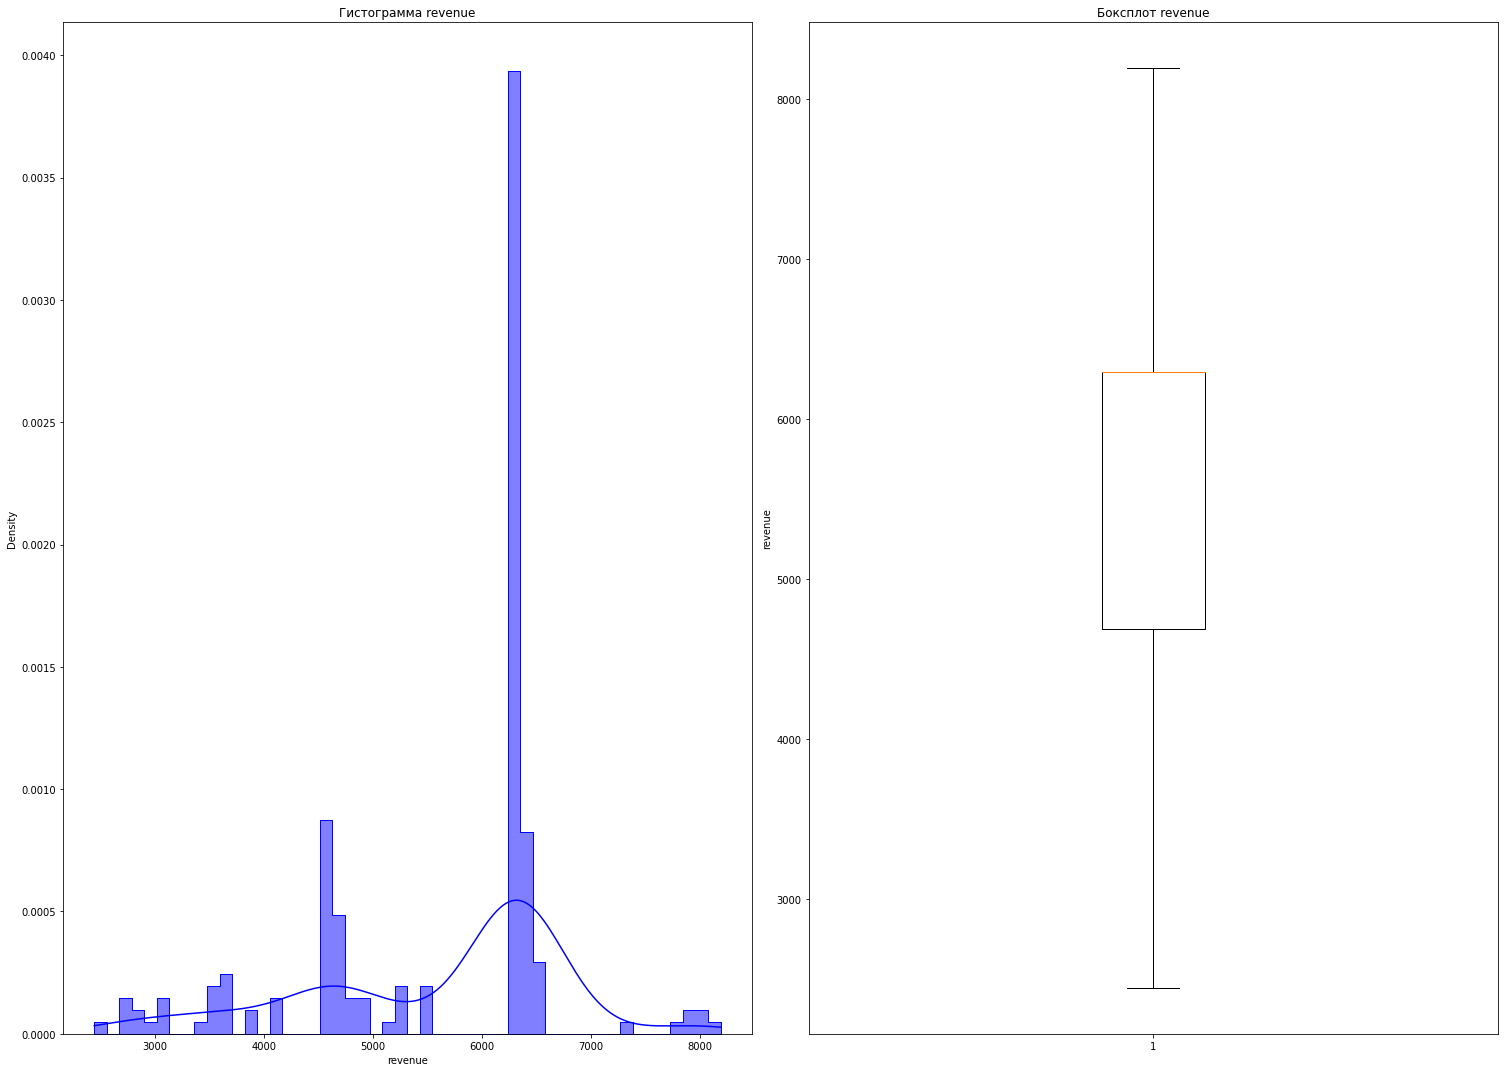

In [236]:
fig, axes = plt.subplots(1, 2, figsize=(21, 15))

# Гистограмма revenue для control
sns.histplot(data=control_prem_no_trial_f['revenue'], bins=50, kde=True, color='blue', ax=axes[0], element='step', stat='density')
axes[0].set_title('Гистограмма revenue')

# Боксплот для control
axes[1].boxplot(control_prem_no_trial_f['revenue'])
axes[1].set_title('Боксплот revenue')
axes[1].set_ylabel('revenue')

plt.tight_layout()
plt.show()

Заново посчитаем **CR** для каждой группы.

In [237]:
# CR для группы test
CR_test = round((test_prem_no_trial_f['uid'].nunique() / test['uid'].nunique()) * 100, 2)

# CR для группы control
CR_control = round((control_prem_no_trial_f['uid'].nunique() / control['uid'].nunique()) * 100, 2)

print(f"CR в test: {CR_test} %")
print()
print(f"CR в control: {CR_control} %")

CR в test: 1.49 %

CR в control: 2.08 %


Конверсия в группе control больше, чем в группе test, но нужно проверить, что это статистически значимое различие, может быть это просто случайность.

Для сравнения конверсий будем использовать z-тест для разности пропорций.

Z-тест для разности пропорций  

**Нулевая гипотеза:** Конверсия в группах test и control статистически не отличается (пропорции равны).  
**Альтерантивная гипотеза:** Конверсия в группах отличается.

In [238]:
# Rол-во платящих пользователей для каждой из групп
pu_test = test_prem_no_trial_f['uid'].nunique()
pu_control = control_prem_no_trial_f['uid'].nunique()

# Кол-во всех пользователей для каждой из групп
u_test = test['uid'].nunique()
u_control = control['uid'].nunique()

# Z-тест для разности пропорций
pu = [pu_test, pu_control]
u = [u_test, u_control]

stat, p = proportions_ztest(pu, u)

print("Z-statistic:", stat, ", CR p-value:", p)

Z-statistic: -2.34610442095487 , CR p-value: 0.01897079180311446


Получаем p-value < 0.05, нулевую гипотезу отклоняем, конверсия в группах test и control статистически различна.

Заново посчитаем **ARPPU** для каждой группы.

In [239]:
# ARPPU для test
test_arppu = test_prem_no_trial_f['revenue'].sum() / test_prem_no_trial_f['uid'].nunique()

# ARPPU для control
control_arppu = control_prem_no_trial_f['revenue'].sum() / control_prem_no_trial_f['uid'].nunique()

print(f"ARPPU в test: {test_arppu}")
print()
print(f"ARPPU в control: {control_arppu}")

ARPPU в test: 8593.8125

ARPPU в control: 5606.268156424581


ARPPU в группе test больше, чем в группе control, но нужно проверить, что это статистически значимое различие, может быть это просто случайность.
Для проверки нам нужно выбрать подходящий тест, поэтому посмотрим на распределение revenue в **отфильтрованных группах** и решим какой тест будем использовать.

По графикам чуть выше наблюдаем, что распределения далеки от нормальных.  
  
Попробуем использовать bootstrap доверительного интервала для разницы средних.

Bootstrap 

**Нулевая гипотеза:** Средние значения ARPPU в отфильтрованных группах test и control статистически не различаются.  
**Альтерантивная гипотеза:** Средние значения различаются.  

Если ноль лежит вне доверительного интервала, то это означает, что с заданной уверенностью (95%) нулевая гипотеза отвергается и изменения считаются статистически значимыми.

In [240]:
# Преобразуем наши столбцы revenue в обоих группах в массивы
arr_rev_test_prem_no_trial = np.array(test_prem_no_trial_f['revenue'])
arr_rev_control_prem_no_trial = np.array(control_prem_no_trial_f['revenue'])

# Функция для вычисления разницы средних (ARPPU test - ARPPU control)
def diff_mean(x, y, axis = 0):
    return np.mean(y, axis = axis) - np.mean(x, axis = axis)

data = (arr_rev_control_prem_no_trial, arr_rev_test_prem_no_trial)

# Запуск бутстрапа для оценки доверительного интервала разницы средних
res = sc.bootstrap(data, statistic = diff_mean, confidence_level = 0.95, n_resamples = 9999, method = 'percentile', vectorized = False)

# Вывод результатов
print(f"Доверительный интервал разницы средних (ARPPU test - ARPPU control): {res.confidence_interval}")

Доверительный интервал разницы средних (ARPPU test - ARPPU control): ConfidenceInterval(low=2164.964180342179, high=3845.7768025488817)


Ноль не лежит в доверительном интервале, это означает, что мы можем отклонить нулевую гипотезу, а значит **средние значения ARPPU в отфильтрованных группах test и control статистически различаются**.

## Итоговые выводы

**ARPU** немного вырос, но этот рост статистически не значим.  

**До фильтрации выбросов**  
**CR** в контрольной группе и так не была большой (всего 2,34 %) в тестовой группе статистически значимо упала до 1,56 % (падение на 0,78 %).  
**ARPPU** статистически значимо вырос с 7495 в контрольной группе до 11962 в тестовой группе (прирост в 59%).  

**После фильтрации выбросов**  
**CR** в контрольной группе стала 2,07 %, в тестовой группе стала 1,49 % (статистически значимое падение на 0,58 %).  
**ARPPU** статистически значимо вырос с 5606 в контрольной группе до 8593 в тестовой группе (прирост в 53%).  

**Вывод**  
Эксперимент дал смешанный результат.  
**Конверсия** просела, значит людей, которые вообще платят, стало меньше. 
**ARPPU** у оставшихся платящих вырос сильно (и до, и после фильтрации выбросов).  
**ARPU** почти не изменился и статистически не отличается от исходного.  

Если для бизнеса главное — больше денег с каждого платящего, можно считать, что гипотеза частично зашла и стоит дальше докручивать механику.  

Если приоритет — не терять платящих и конверсию, то в текущем виде эксперимент скорее неудачный и изменения в таком виде раскатывать рано.  